In [0]:
from getpass import getpass 


!pip install -e "git+https://github.com/lofifnc/pandemic.git#egg=pandemic" 

In [0]:
from pandemic.learning.environment import PandemicEnvironment
from pandemic.learning.transition import ReplayMemory
from pandemic.learning.transition import Transition
from statistics import mean 
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F


env = PandemicEnvironment(num_epidemic_cards=4, characters=(5,7))

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [0]:
def net(n_in, n_out, n_h):
    return nn.Sequential(nn.Linear(n_in, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_out),
                     nn.Sigmoid())

In [0]:
class DQN(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # I don't know what a fucking conv net is...
        linear_input_size = inputs
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


In [0]:
  class LSTM(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim

        #  , dropout=0.2
        self.lstm = nn.LSTM(input_size, hidden_dim)

        # The linear layer that maps from hidden state space to output
        self.hidden2tag = nn.Linear(hidden_dim, output_size)

    def forward(self, sentence):
        lstm_out, _ = self.lstm(sentence.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [7]:
BATCH_SIZE = 512
EPS_START = 0.9
EPS_END = \
    0.05
EPS_DECAY = 20000
TARGET_UPDATE = 10
GAMMA = 0.999
PLOT_STEPS=10


# Get number of actions from gym action space
action_space_dim = env.action_space.shape[0]

# no screen
obs_space_dim = env.observation_space.shape[0] + action_space_dim
print(obs_space_dim)
hidden_nodes = int(2/3 * (obs_space_dim * action_space_dim))
print(f"The number of hidden nodes is {hidden_nodes}.")


policy_net = LSTM(obs_space_dim, 1000,  action_space_dim).to(device)
target_net = LSTM(obs_space_dim, 1000, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = torch.optim.Adam(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0

def random_action(action_space):
    idx_nonzero = np.nonzero(action_space)[0]
    return np.random.choice(idx_nonzero)

def select_random_action(action_space):
     return torch.tensor([[random_action(action_space)]], device=device, dtype=torch.long)

def select_action(state, action_space):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            policy_out = policy_net(state)
            return policy_out.max(1)[1].view(1, 1)
    else:
        # select random non zero value from action space
        return torch.tensor([[random_action(action_space)]], device=device, dtype=torch.long)


episode_durations = []
episode_reward = []
episode_loss = []


def plot_timeline(ax, np_arr, name):
    arr_t = torch.tensor(np_arr, dtype=torch.float)
    ax.set_xlabel('Episode')
    ax.set_ylabel(name)
    ax.plot(arr_t.numpy())
    # Take 100 episode averages and plot them too
    if len(arr_t) >= 100:
        means = arr_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax.plot(means.numpy())

def plot_durations():
    fig, axs = plt.subplots(3,1, figsize=(16,12))
#     plt.title('Training...')
#     plt.clf()
    plot_timeline(axs[0], episode_durations, "Steps")
        
    plot_timeline(axs[1], episode_loss, "Loss")
    plot_timeline(axs[2], episode_reward, "Reward")
    plt.show()
    plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         display.clear_output(wait=True)
#         display.display(plt.gcf())

def get_state(env):
    return torch.from_numpy(np.concatenate((env.observation_space, env.action_space), axis=None)).float().to(device).view(1,obs_space_dim)


1212
The number of hidden nodes is 753056.


In [0]:
def optimize_model(done):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    if done:
        episode_loss.append(loss)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # maybe not
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [9]:
# run random games for a while to quickly fill up memory
env.reset()
memory_push = memory.push
state = get_state(env)
for t in range(5000):
    # Select and perform an action
    action = select_random_action(env.action_space)
    _, reward, done, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device).float()

    # Observe new state
    if not done:
        next_state = get_state(env)
    else:
        print("reward: ", reward)
        next_state = None

    # Store the transition in memory
    memory_push(state, action, next_state, reward)

    # Move to the next state
    state = next_state
    if done:
        env.reset()
        state = get_state(env)

reward:  tensor([0.0969], device='cuda:0')
reward:  tensor([-0.0352], device='cuda:0')
reward:  tensor([-0.5398], device='cuda:0')
reward:  tensor([0.0070], device='cuda:0')
reward:  tensor([-0.8342], device='cuda:0')
reward:  tensor([0.1070], device='cuda:0')
reward:  tensor([-0.8291], device='cuda:0')
reward:  tensor([-0.8421], device='cuda:0')
reward:  tensor([-0.5069], device='cuda:0')
reward:  tensor([0.0820], device='cuda:0')
reward:  tensor([0.0860], device='cuda:0')
reward:  tensor([-0.3433], device='cuda:0')
reward:  tensor([-0.4839], device='cuda:0')
reward:  tensor([-0.9690], device='cuda:0')
reward:  tensor([-0.2420], device='cuda:0')
reward:  tensor([-1.1830], device='cuda:0')
reward:  tensor([-0.3523], device='cuda:0')
reward:  tensor([-0.1139], device='cuda:0')
reward:  tensor([-1.0510], device='cuda:0')
reward:  tensor([-0.0719], device='cuda:0')
reward:  tensor([-0.1179], device='cuda:0')
reward:  tensor([0.0950], device='cuda:0')
reward:  tensor([0.0750], device='cuda

reward:  tensor([-0.1398], device='cuda:0')
DirectFlight(player=5, destination=25) 0.01491110011343777
DirectFlight(player=5, destination=23) 0.008955550056718884
DirectFlight(player=5, destination=20) 0.009955550056718884
DriveFerry(player=5, destination=19) 0.010955550056718884
Wait 0.010955550056718884
Wait 0.010955550056718884
Wait 0.010955550056718884
Wait 0.010955550056718884
DriveFerry(player=7, destination=10) 0.011955550056718885
DriveFerry(player=7, destination=31) 0.012955550056718885
DriveFerry(player=7, destination=48) 0.013955550056718884
DriveFerry(player=7, destination=34) 0.014955550056718885
Wait 0.02191110011343777
Wait 0.028866650170156653
Wait 0.028866650170156653
Wait 0.028866650170156653
DriveFerry(player=5, destination=8) 0.029866650170156654
DriveFerry(player=5, destination=37) 0.030866650170156655
DriveFerry(player=5, destination=18) 0.03186665017015665
DriveFerry(player=5, destination=11) 0.03286665017015665
Wait 0.03286665017015665
Wait 0.03286665017015665
W

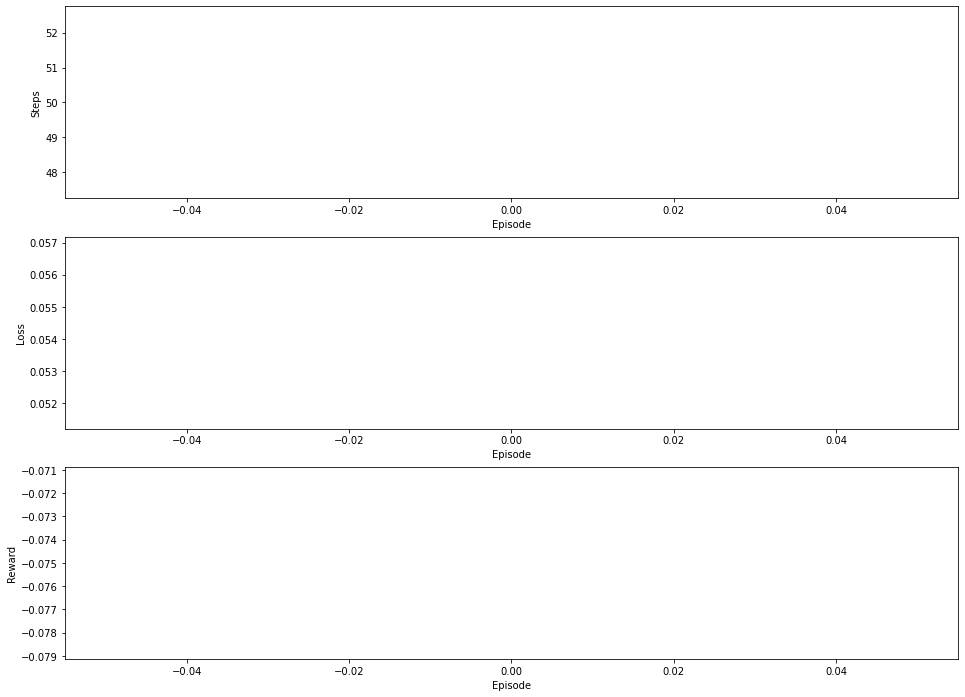

reward:  tensor([-0.5109], device='cuda:0')
reward:  tensor([0.0029], device='cuda:0')
reward:  tensor([0.1029], device='cuda:0')
reward:  tensor([0.0850], device='cuda:0')
reward:  tensor([-0.8181], device='cuda:0')
reward:  tensor([-0.4630], device='cuda:0')
reward:  tensor([-0.6779], device='cuda:0')
reward:  tensor([-0.9981], device='cuda:0')
reward:  tensor([-0.6679], device='cuda:0')
reward:  tensor([-0.2611], device='cuda:0')
ResilientPopulation(player=7, discard_city=9) 0.007955550056718885
DirectFlight(player=5, destination=13) 0.008955550056718884
DirectFlight(player=5, destination=25) 0.009955550056718884
DirectFlight(player=5, destination=43) 0.004
DriveFerry(player=5, destination=12) 0.005
Wait 0.005
Wait 0.011955550056718885
Wait 0.011955550056718885
Wait 0.011955550056718885
DirectFlight(player=7, destination=41) 0.012955550056718885
DirectFlight(player=7, destination=34) 0.013955550056718884
DriveFerry(player=7, destination=26) 0.014955550056718885
DriveFerry(player=7, 

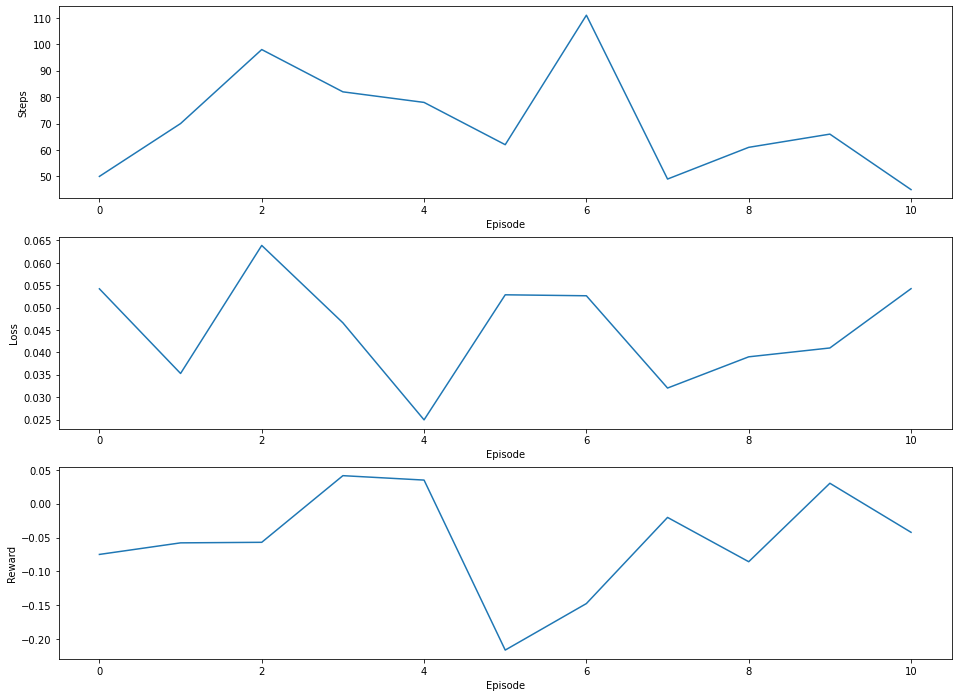

reward:  tensor([-0.1149], device='cuda:0')
reward:  tensor([-0.8061], device='cuda:0')
reward:  tensor([-1.1959], device='cuda:0')
reward:  tensor([-0.3922], device='cuda:0')
reward:  tensor([0.1030], device='cuda:0')
reward:  tensor([-0.8132], device='cuda:0')
reward:  tensor([0.0999], device='cuda:0')
reward:  tensor([0.0959], device='cuda:0')
reward:  tensor([0.0107], device='cuda:0')
reward:  tensor([-0.6679], device='cuda:0')
DirectFlight(player=5, destination=25) 0.01491110011343777
DriveFerry(player=5, destination=10) 0.01591110011343777
DriveFerry(player=5, destination=2) 0.016911100113437768
DriveFerry(player=5, destination=29) 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
GovernmentGrant(player=5, target_city=30) 0.01891110011343777
Wait 0.01891110011343777
DirectFlight(player=7, destination=7) 0.019911100113437767
DriveFerry(player=7, destination=40) 0.020911100113437768
DriveFerry(player=7, destination=6) 0.02191110011343777
DriveFerry(player=7, des

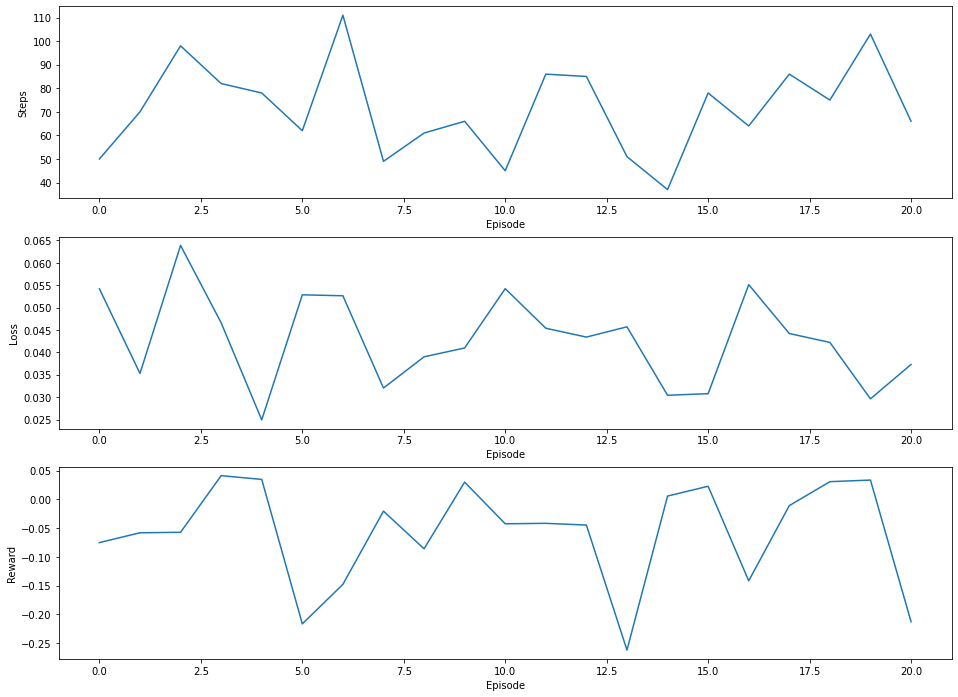

reward:  tensor([-0.0828], device='cuda:0')
reward:  tensor([0.1019], device='cuda:0')
reward:  tensor([-0.0611], device='cuda:0')
reward:  tensor([0.1060], device='cuda:0')
reward:  tensor([-0.4929], device='cuda:0')
reward:  tensor([-0.8331], device='cuda:0')
reward:  tensor([-0.0869], device='cuda:0')
reward:  tensor([-0.8241], device='cuda:0')
reward:  tensor([-0.8383], device='cuda:0')
reward:  tensor([-0.8001], device='cuda:0')
DirectFlight(player=5, destination=13) 0.007955550056718885
DriveFerry(player=5, destination=4) 0.008955550056718884
DriveFerry(player=5, destination=13) 0.009955550056718884
DriveFerry(player=5, destination=14) 0.010955550056718884
Wait 0.01504669193785357
Wait 0.01504669193785357
Wait 0.01504669193785357
Wait 0.01504669193785357
CharterFlight(player=7, destination=15) 0.01604669193785357
DriveFerry(player=7, destination=32) 0.01704669193785357
DirectFlight(player=7, destination=27) 0.01804669193785357
DriveFerry(player=7, destination=45) 0.01904669193785

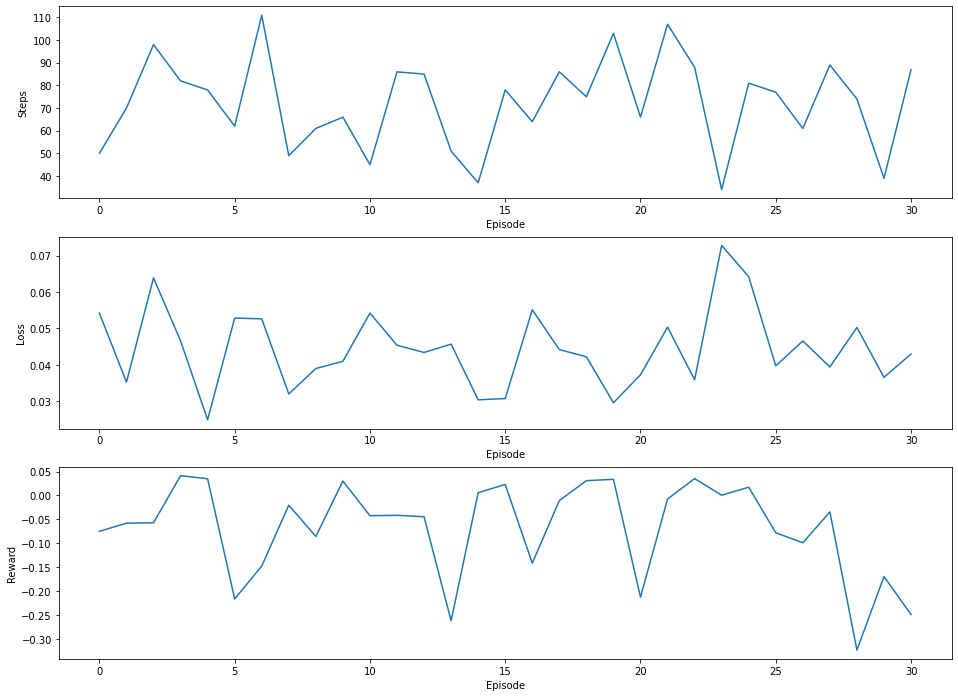

reward:  tensor([-0.8371], device='cuda:0')
reward:  tensor([-0.2451], device='cuda:0')
reward:  tensor([-0.4949], device='cuda:0')
reward:  tensor([-0.9880], device='cuda:0')
reward:  tensor([-0.8342], device='cuda:0')
reward:  tensor([-0.2201], device='cuda:0')
reward:  tensor([0.0939], device='cuda:0')
reward:  tensor([-0.3683], device='cuda:0')
reward:  tensor([-0.2091], device='cuda:0')
reward:  tensor([-0.6379], device='cuda:0')
GovernmentGrant(player=7, target_city=26) 0.01204669193785357
CharterFlight(player=5, destination=48) 0.01304669193785357
DriveFerry(player=5, destination=29) 0.01404669193785357
DriveFerry(player=5, destination=28) 0.01504669193785357
DriveFerry(player=5, destination=23) 0.01604669193785357
Wait 0.01604669193785357
Wait 0.023002241994572455
Wait 0.023002241994572455
Wait 0.023002241994572455
DriveFerry(player=7, destination=10) 0.024002241994572453
DriveFerry(player=7, destination=31) 0.025002241994572454
TreatDisease(city=31, target_virus=1) 0.026002241

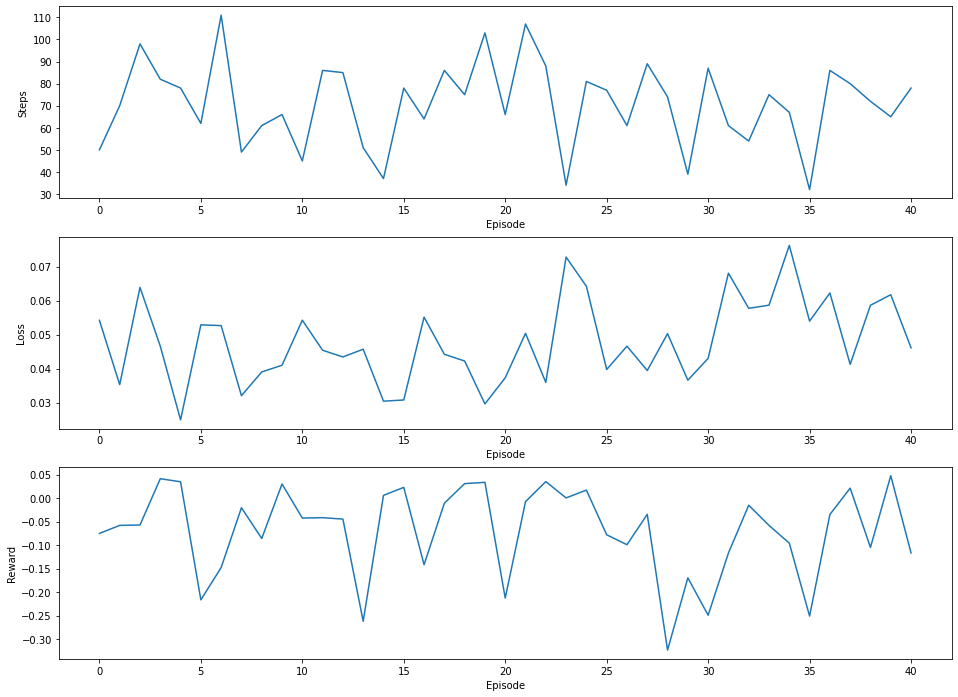

reward:  tensor([-0.8161], device='cuda:0')
reward:  tensor([-0.8172], device='cuda:0')
reward:  tensor([-0.8672], device='cuda:0')
reward:  tensor([-0.8230], device='cuda:0')
reward:  tensor([-0.8192], device='cuda:0')
reward:  tensor([-0.9681], device='cuda:0')
reward:  tensor([-0.8083], device='cuda:0')
reward:  tensor([-1.2239], device='cuda:0')
reward:  tensor([-0.9972], device='cuda:0')
reward:  tensor([-0.9669], device='cuda:0')
DirectFlight(player=5, destination=9) 0.01491110011343777
DriveFerry(player=5, destination=11) 0.01591110011343777
DriveFerry(player=5, destination=46) 0.016911100113437768
DirectFlight(player=5, destination=33) 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
DriveFerry(player=7, destination=10) 0.01891110011343777
DriveFerry(player=7, destination=28) 0.019911100113437767
DriveFerry(player=7, destination=25) 0.020911100113437768
DriveFerry(player=7, destination=28) 0.0219111001134377

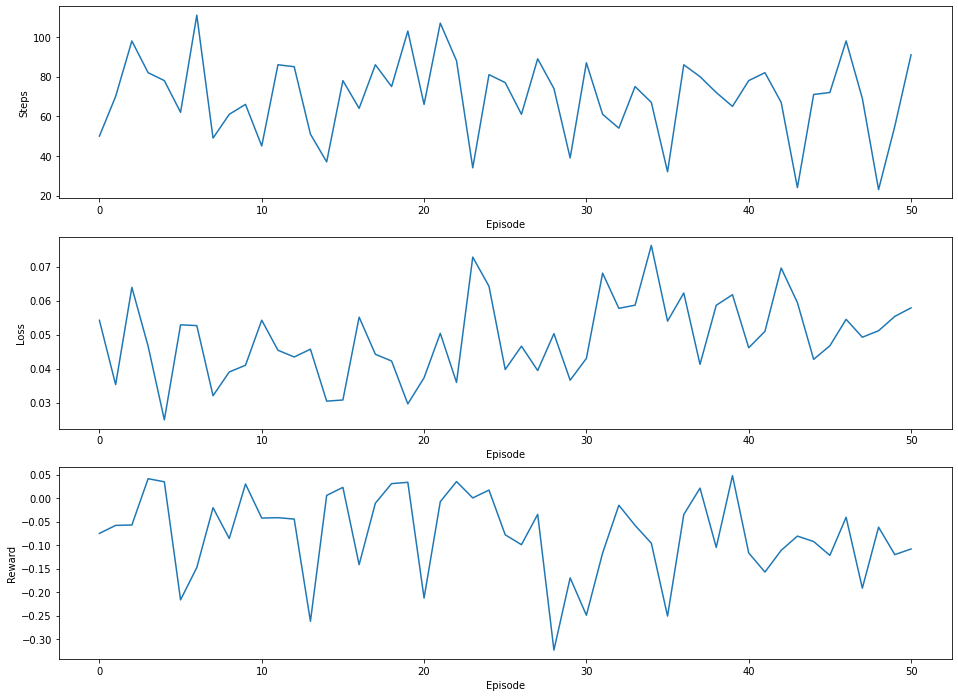

reward:  tensor([0.0138], device='cuda:0')
reward:  tensor([-0.2420], device='cuda:0')
reward:  tensor([-0.1932], device='cuda:0')
reward:  tensor([0.0148], device='cuda:0')
reward:  tensor([-0.8061], device='cuda:0')
reward:  tensor([-1.0160], device='cuda:0')
reward:  tensor([-0.2101], device='cuda:0')
reward:  tensor([0.1109], device='cuda:0')
reward:  tensor([-0.7990], device='cuda:0')
reward:  tensor([-1.2150], device='cuda:0')
DriveFerry(player=5, destination=29) 0.019002241994572455
CharterFlight(player=5, destination=36) 0.01304669193785357
DriveFerry(player=5, destination=12) 0.01404669193785357
DirectFlight(player=5, destination=13) 0.01504669193785357
Wait 0.01504669193785357
Airlift(player=5, target_player=5, destination=20) 0.023002241994572455
Wait 0.023002241994572455
Wait 0.023002241994572455
DriveFerry(player=7, destination=29) 0.024002241994572453
DirectFlight(player=7, destination=26) 0.020911100113437768
DirectFlight(player=7, destination=48) 0.014955550056718885
Di

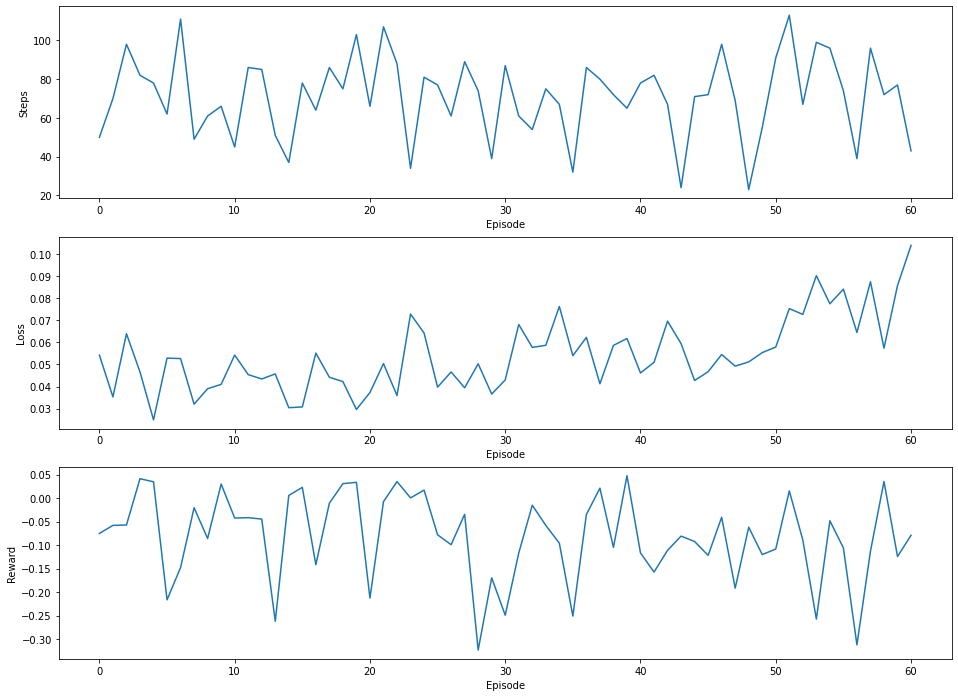

reward:  tensor([-1.1880], device='cuda:0')
reward:  tensor([0.1049], device='cuda:0')
reward:  tensor([-0.1389], device='cuda:0')
reward:  tensor([0.1249], device='cuda:0')
reward:  tensor([-0.6568], device='cuda:0')
reward:  tensor([-0.1481], device='cuda:0')
reward:  tensor([0.0208], device='cuda:0')
reward:  tensor([0.1120], device='cuda:0')
reward:  tensor([-0.5279], device='cuda:0')
reward:  tensor([0.1100], device='cuda:0')
DirectFlight(player=5, destination=6) 0.007955550056718885
DriveFerry(player=5, destination=40) 0.008955550056718884
DriveFerry(player=5, destination=7) 0.009955550056718884
DirectFlight(player=5, destination=1) 0.010955550056718884
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
DirectFlight(player=7, destination=17) 0.011955550056718885
DirectFlight(player=7, destination=31) 0.012955550056718885
DirectFlight(player=7, destination=14) 0.013955550056718884
DriveFerry(player=7, destination=4) 0.01495555005671

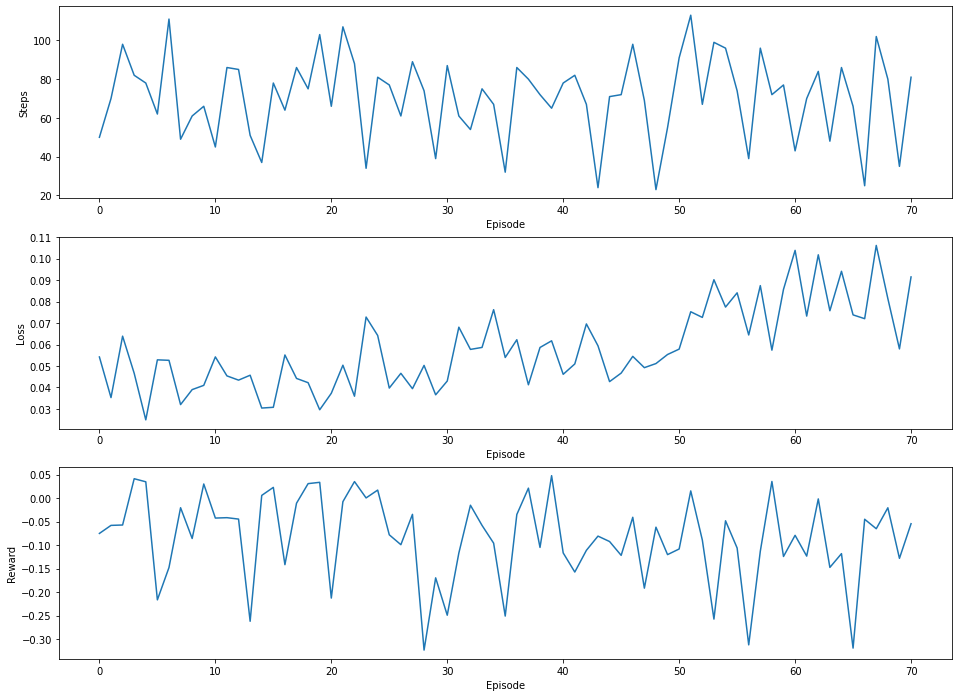

reward:  tensor([-0.8531], device='cuda:0')
reward:  tensor([-0.8123], device='cuda:0')
reward:  tensor([-0.7853], device='cuda:0')
reward:  tensor([-0.7811], device='cuda:0')
reward:  tensor([0.1238], device='cuda:0')
reward:  tensor([0.1120], device='cuda:0')
reward:  tensor([-1.0200], device='cuda:0')
reward:  tensor([-0.3343], device='cuda:0')
reward:  tensor([-0.1019], device='cuda:0')
reward:  tensor([-0.3792], device='cuda:0')
DirectFlight(player=5, destination=3) 0.007955550056718885
DirectFlight(player=5, destination=29) 0.002
DriveFerry(player=5, destination=6) 0.003
DirectFlight(player=5, destination=22) 0.004
Wait 0.004
Wait 0.010955550056718884
Wait 0.010955550056718884
Wait 0.010955550056718884
DirectFlight(player=7, destination=7) 0.011955550056718885
DirectFlight(player=7, destination=32) 0.012955550056718885
DirectFlight(player=7, destination=45) 0.013955550056718884
DriveFerry(player=7, destination=14) 0.014955550056718885
Wait 0.014955550056718885
Wait 0.014955550056

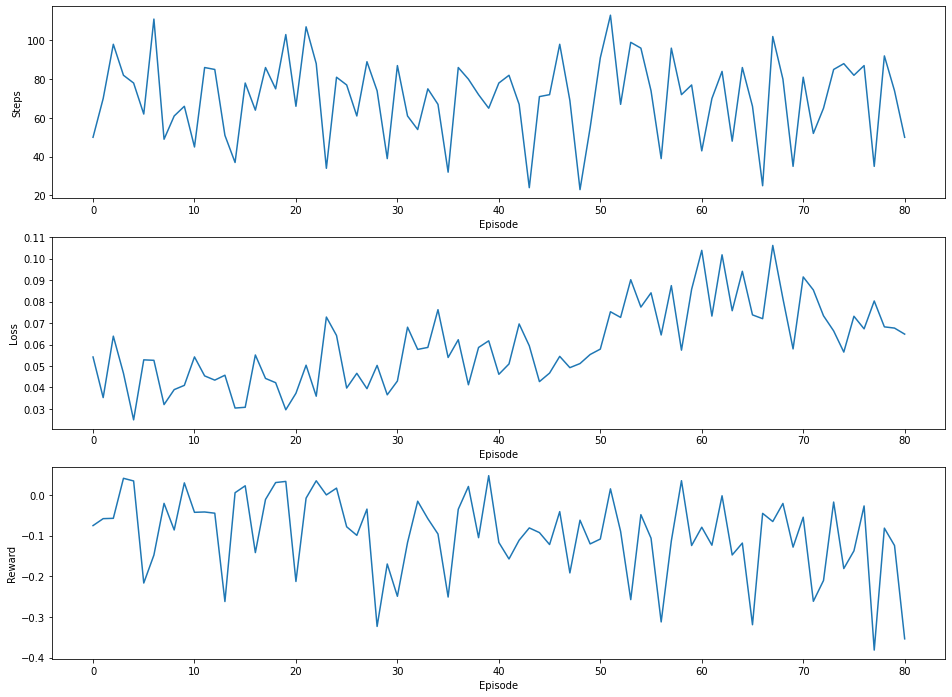

reward:  tensor([0.0970], device='cuda:0')
reward:  tensor([-1.3824], device='cuda:0')
reward:  tensor([-0.6909], device='cuda:0')
reward:  tensor([-0.3693], device='cuda:0')
reward:  tensor([-0.6909], device='cuda:0')
reward:  tensor([-0.2090], device='cuda:0')
reward:  tensor([-0.3503], device='cuda:0')
reward:  tensor([-1.0251], device='cuda:0')
reward:  tensor([0.1010], device='cuda:0')
reward:  tensor([-0.6079], device='cuda:0')
DriveFerry(player=5, destination=48) 0.01491110011343777
DriveFerry(player=5, destination=29) 0.01591110011343777
TreatDisease(city=29, target_virus=3) 0.016911100113437768
DriveFerry(player=5, destination=48) 0.01791110011343777
Forecast(player=7) 0.01891110011343777
ChooseCard(player=5, card=6) 0.019911100113437767
ChooseCard(player=5, card=22) 0.020911100113437768
ChooseCard(player=5, card=17) 0.02191110011343777
ChooseCard(player=5, card=13) 0.02291110011343777
ChooseCard(player=5, card=19) 0.02391110011343777
ChooseCard(player=5, card=4) 0.03186665017

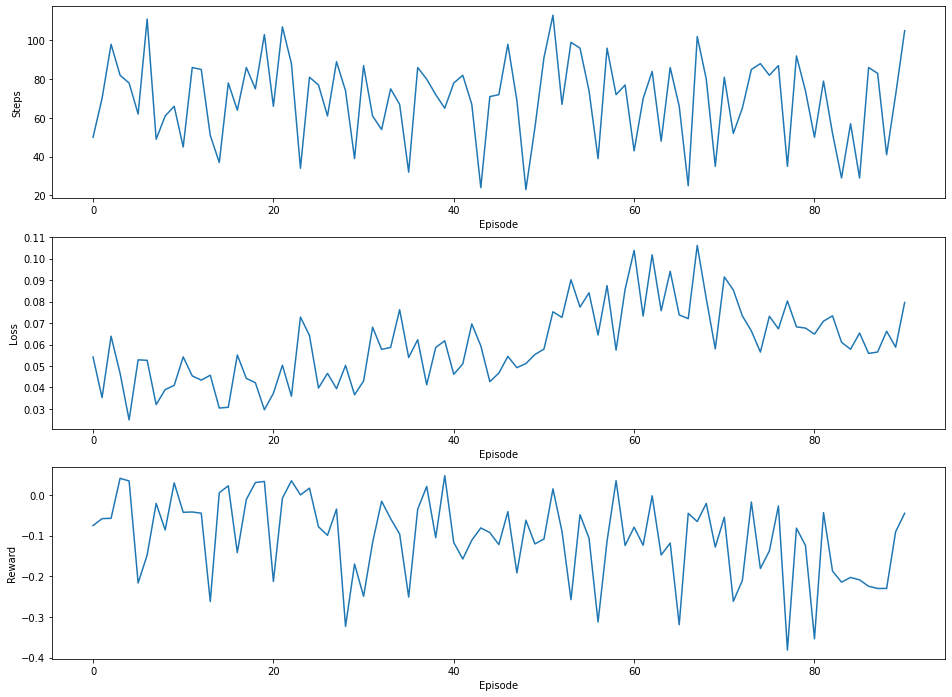

reward:  tensor([-1.0070], device='cuda:0')
reward:  tensor([-0.2140], device='cuda:0')
reward:  tensor([0.0118], device='cuda:0')
reward:  tensor([-0.6399], device='cuda:0')
reward:  tensor([-0.9971], device='cuda:0')
reward:  tensor([0.1060], device='cuda:0')
reward:  tensor([-0.8420], device='cuda:0')
reward:  tensor([-0.8121], device='cuda:0')
reward:  tensor([-0.8391], device='cuda:0')
reward:  tensor([-0.8151], device='cuda:0')
DirectFlight(player=5, destination=37) 0.01491110011343777
DirectFlight(player=5, destination=33) 0.008955550056718884
DirectFlight(player=5, destination=13) 0.009955550056718884
DriveFerry(player=5, destination=27) 0.010955550056718884
Wait 0.010955550056718884
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
DirectFlight(player=7, destination=38) 0.011955550056718885
DirectFlight(player=7, destination=18) 0.012955550056718885
DirectFlight(player=7, destination=29) 0.013955550056718884
DriveFerry(player=7, destination=2) 0.014955

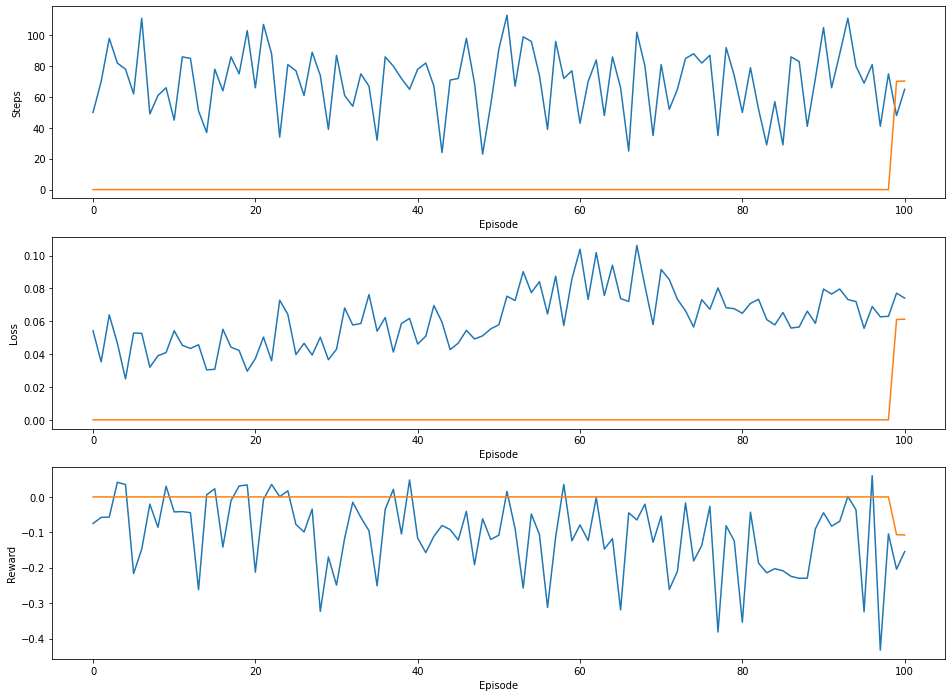

reward:  tensor([-1.3534], device='cuda:0')
reward:  tensor([-0.2580], device='cuda:0')
reward:  tensor([-0.7922], device='cuda:0')
reward:  tensor([-0.3113], device='cuda:0')
reward:  tensor([-0.0142], device='cuda:0')
reward:  tensor([-1.1831], device='cuda:0')
reward:  tensor([-0.5319], device='cuda:0')
reward:  tensor([-1.0490], device='cuda:0')
reward:  tensor([-0.8231], device='cuda:0')
reward:  tensor([-0.0023], device='cuda:0')
DriveFerry(player=5, destination=10) 0.01491110011343777
DriveFerry(player=5, destination=25) 0.01591110011343777
DirectFlight(player=5, destination=36) 0.016911100113437768
DriveFerry(player=5, destination=24) 0.01791110011343777
Wait 0.022002241994572454
Wait 0.022002241994572454
Wait 0.022002241994572454
Wait 0.022002241994572454
DriveFerry(player=7, destination=29) 0.023002241994572455
DriveFerry(player=7, destination=6) 0.024002241994572453
DriveFerry(player=7, destination=40) 0.025002241994572454
DriveFerry(player=7, destination=6) 0.02600224199457

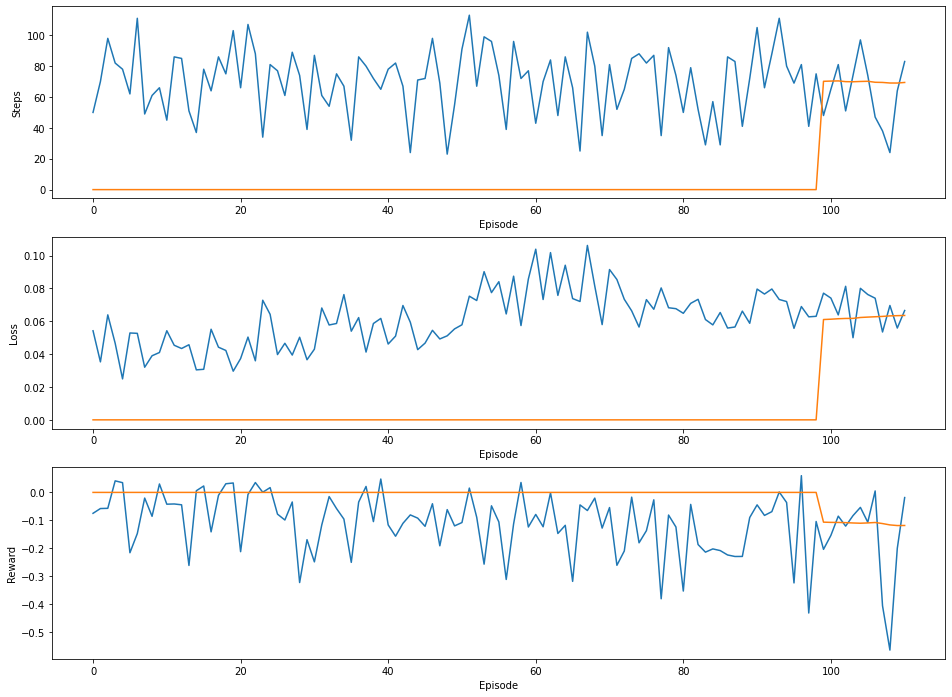

reward:  tensor([-0.9820], device='cuda:0')
reward:  tensor([-1.0371], device='cuda:0')
reward:  tensor([-0.9770], device='cuda:0')
reward:  tensor([-0.6309], device='cuda:0')
reward:  tensor([-0.4579], device='cuda:0')
reward:  tensor([-0.8142], device='cuda:0')
reward:  tensor([-0.7783], device='cuda:0')
reward:  tensor([-0.3054], device='cuda:0')
reward:  tensor([-0.2620], device='cuda:0')
reward:  tensor([-0.6399], device='cuda:0')
DirectFlight(player=5, destination=40) 0.007955550056718885
DirectFlight(player=5, destination=44) 0.008955550056718884
DriveFerry(player=5, destination=25) 0.009955550056718884
DriveFerry(player=5, destination=44) 0.010955550056718884
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
DriveFerry(player=7, destination=29) 0.01891110011343777
DriveFerry(player=7, destination=2) 0.019911100113437767
DirectFlight(player=7, destination=3) 0.013955550056718884
DriveFerry(player=7, destination=15) 0.014955550056

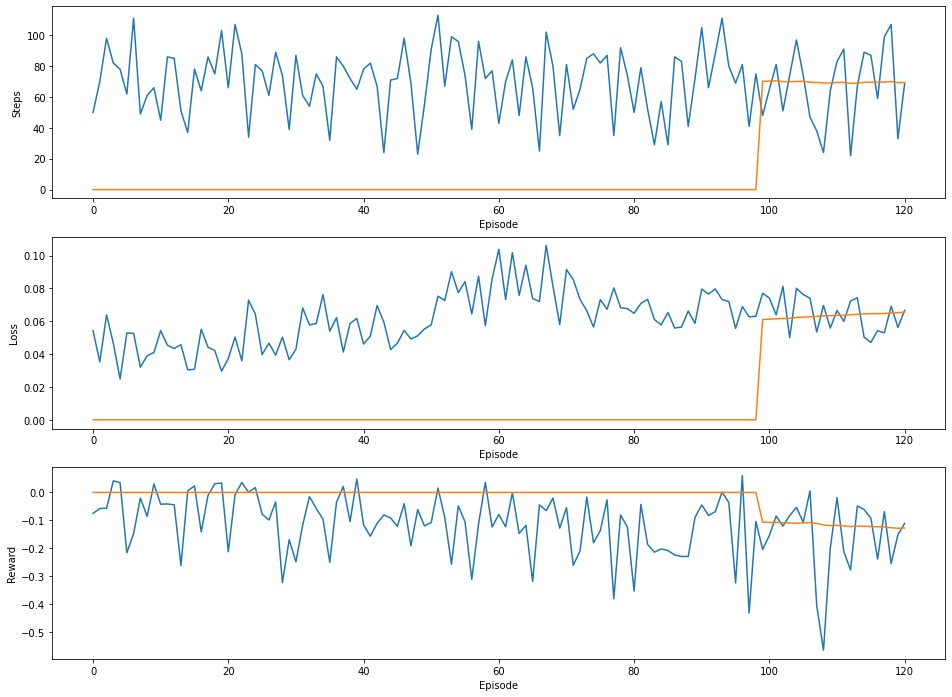

reward:  tensor([0.0027], device='cuda:0')
reward:  tensor([-0.8031], device='cuda:0')
reward:  tensor([-0.3663], device='cuda:0')
reward:  tensor([-0.8041], device='cuda:0')
reward:  tensor([-0.3602], device='cuda:0')
reward:  tensor([-0.0928], device='cuda:0')
reward:  tensor([-0.5490], device='cuda:0')
reward:  tensor([-0.1921], device='cuda:0')
reward:  tensor([-0.8372], device='cuda:0')
reward:  tensor([-0.2400], device='cuda:0')
DriveFerry(player=5, destination=29) 0.02595779205129134
DriveFerry(player=5, destination=28) 0.02695779205129134
DriveFerry(player=5, destination=23) 0.027957792051291338
DriveFerry(player=5, destination=39) 0.02895779205129134
Wait 0.03591334210801023
Wait 0.03882612996018575
Wait 0.03882612996018575
Wait 0.03882612996018575
DriveFerry(player=7, destination=10) 0.039826129960185745
CharterFlight(player=7, destination=14) 0.03387057990346686
DriveFerry(player=7, destination=42) 0.03487057990346686
DriveFerry(player=7, destination=14) 0.035870579903466863

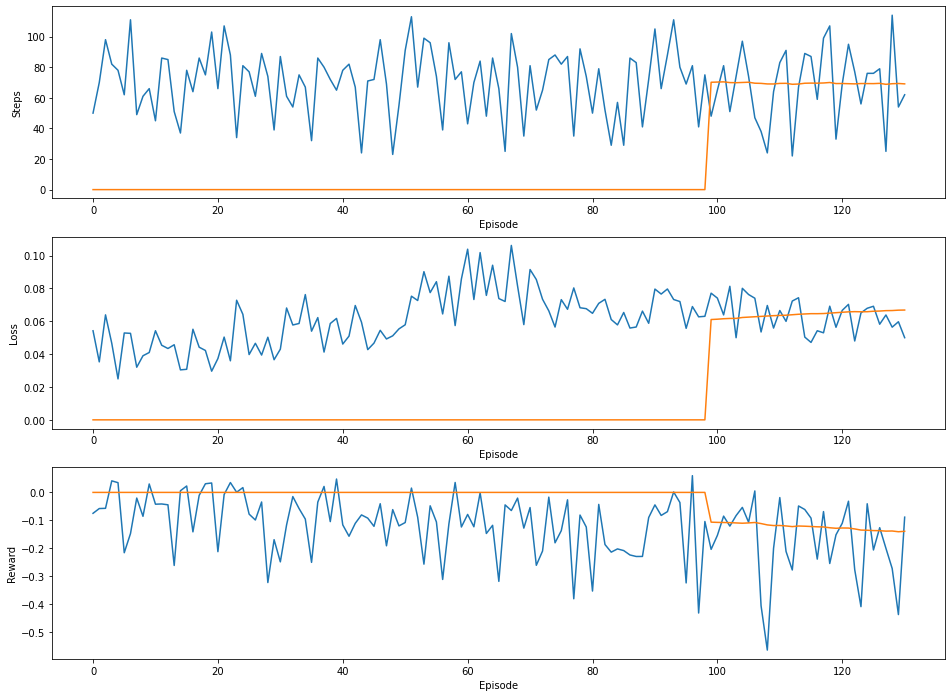

reward:  tensor([-1.1800], device='cuda:0')
reward:  tensor([-1.1978], device='cuda:0')
reward:  tensor([-0.3173], device='cuda:0')
reward:  tensor([-1.1510], device='cuda:0')
reward:  tensor([-0.4758], device='cuda:0')
reward:  tensor([-0.6489], device='cuda:0')
reward:  tensor([-1.0271], device='cuda:0')
reward:  tensor([0.1158], device='cuda:0')
reward:  tensor([-0.8211], device='cuda:0')
reward:  tensor([-0.8391], device='cuda:0')
GovernmentGrant(player=5, target_city=37) 0.007955550056718885
ShuttleFlight(player=5, destination=37) 0.008955550056718884
DriveFerry(player=5, destination=3) 0.009955550056718884
DirectFlight(player=5, destination=14) 0.010955550056718884
DirectFlight(player=5, destination=31) 0.011955550056718885
Wait 0.011955550056718885
Wait 0.01891110011343777
Wait 0.01891110011343777
Wait 0.01891110011343777
DirectFlight(player=7, destination=45) 0.019911100113437767
DriveFerry(player=7, destination=27) 0.020911100113437768
DirectFlight(player=7, destination=6) 0.0

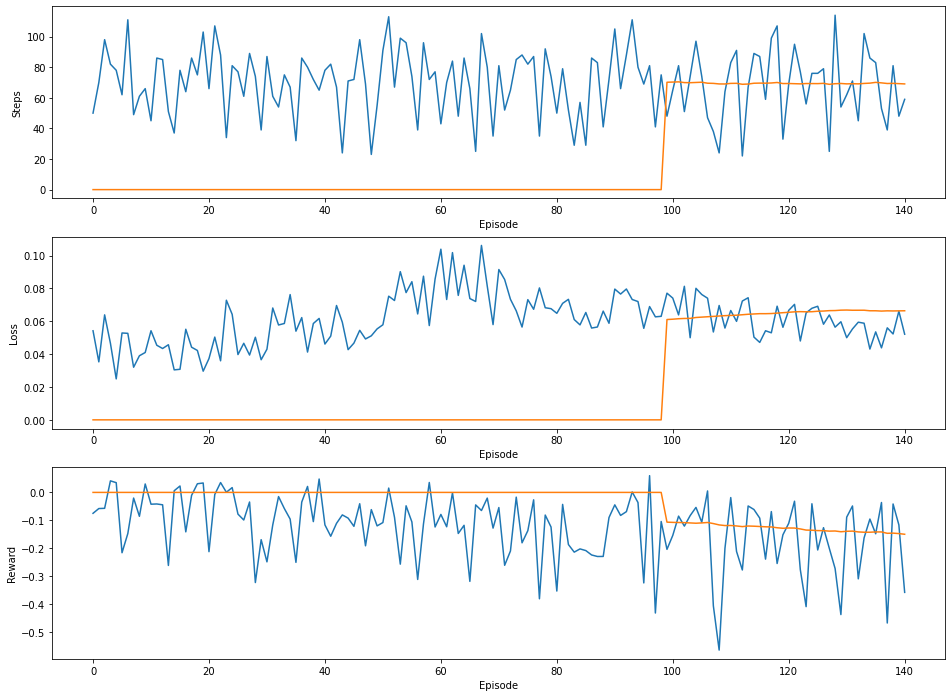

reward:  tensor([0.0108], device='cuda:0')
reward:  tensor([-1.1789], device='cuda:0')
reward:  tensor([-1.0420], device='cuda:0')
reward:  tensor([-0.1861], device='cuda:0')
reward:  tensor([-0.8171], device='cuda:0')
reward:  tensor([0.1229], device='cuda:0')
reward:  tensor([-0.8131], device='cuda:0')
reward:  tensor([-0.8103], device='cuda:0')
reward:  tensor([-0.6779], device='cuda:0')
reward:  tensor([-0.8063], device='cuda:0')
DriveFerry(player=5, destination=10) 0.007955550056718885
DriveFerry(player=5, destination=25) 0.008955550056718884
DriveFerry(player=5, destination=10) 0.009955550056718884
CharterFlight(player=5, destination=23) 0.010955550056718884
Wait 0.01791110011343777
Wait 0.022002241994572454
Wait 0.022002241994572454
Wait 0.022002241994572454
DriveFerry(player=7, destination=10) 0.023002241994572455
DriveFerry(player=7, destination=31) 0.024002241994572453
DriveFerry(player=7, destination=10) 0.025002241994572454
DriveFerry(player=7, destination=38) 0.02600224199

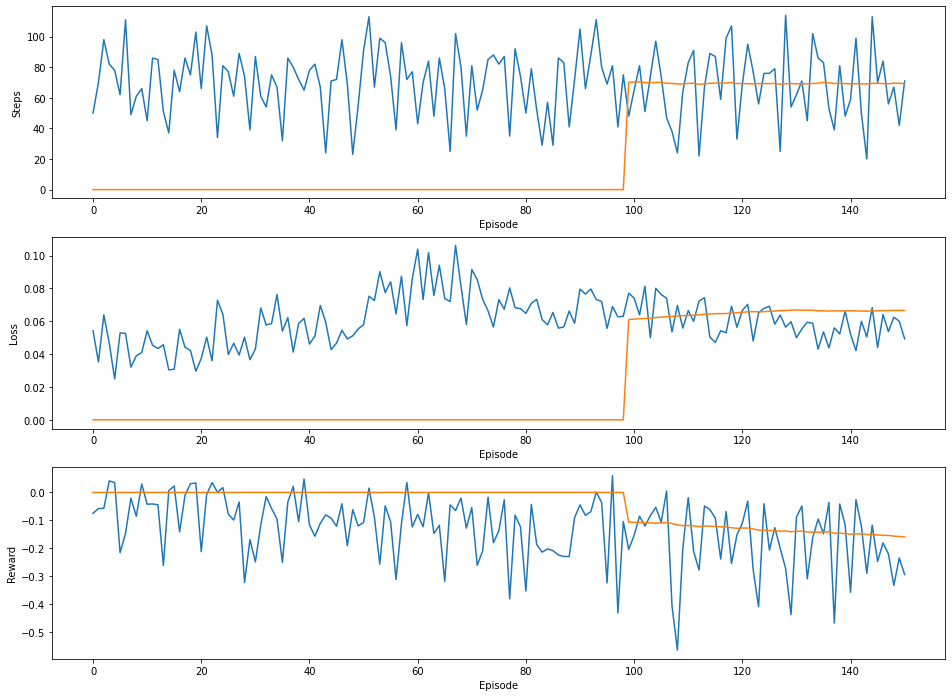

reward:  tensor([-0.8441], device='cuda:0')
reward:  tensor([-0.2471], device='cuda:0')
reward:  tensor([-0.6319], device='cuda:0')
reward:  tensor([-0.8101], device='cuda:0')
reward:  tensor([-0.3392], device='cuda:0')
reward:  tensor([-1.0241], device='cuda:0')
reward:  tensor([-0.8042], device='cuda:0')
reward:  tensor([-1.0270], device='cuda:0')
reward:  tensor([-1.0092], device='cuda:0')
reward:  tensor([-0.7922], device='cuda:0')
DriveFerry(player=5, destination=48) 0.019002241994572455
CharterFlight(player=5, destination=39) 0.01304669193785357
DriveFerry(player=5, destination=23) 0.01404669193785357
CharterFlight(player=5, destination=37) 0.01504669193785357
Wait 0.01504669193785357
Wait 0.01504669193785357
Wait 0.022002241994572454
Wait 0.022002241994572454
Wait -0.017997758005427546
DriveFerry(player=7, destination=10) -0.016997758005427546
TreatDisease(city=10, target_virus=1) -0.015997758005427548
DirectFlight(player=7, destination=16) -0.019088899886562233
DirectFlight(pla

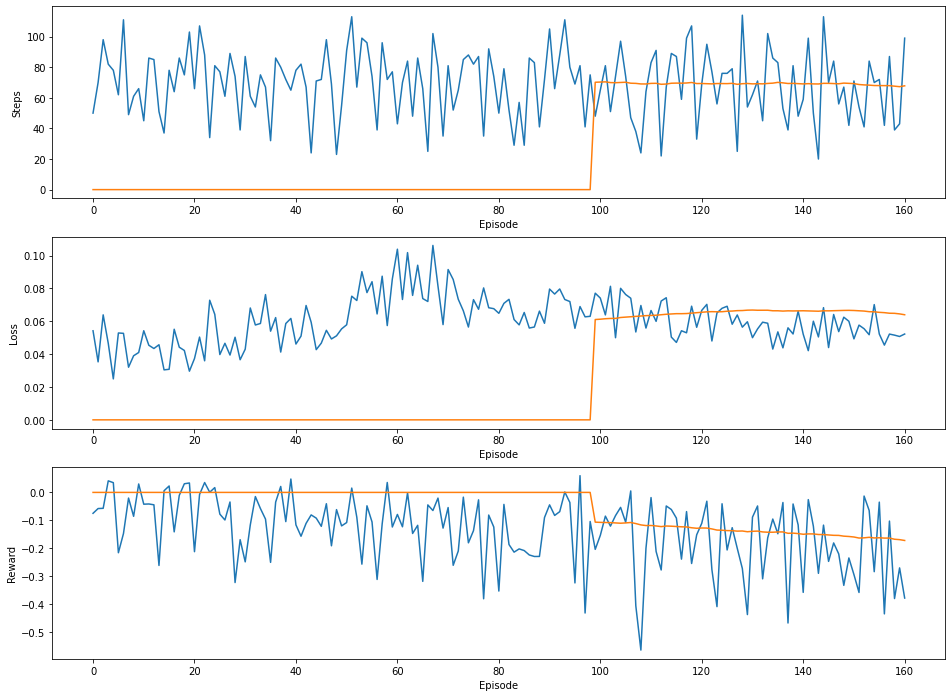

reward:  tensor([-0.2270], device='cuda:0')
reward:  tensor([0.1029], device='cuda:0')
reward:  tensor([-1.1940], device='cuda:0')
reward:  tensor([-1.1720], device='cuda:0')
reward:  tensor([-0.6630], device='cuda:0')
reward:  tensor([-0.0172], device='cuda:0')
reward:  tensor([-0.6289], device='cuda:0')
reward:  tensor([-0.7830], device='cuda:0')
reward:  tensor([-0.6389], device='cuda:0')
reward:  tensor([-1.1969], device='cuda:0')
DriveFerry(player=5, destination=48) 0.01491110011343777
DirectFlight(player=5, destination=43) 0.01591110011343777
DirectFlight(player=5, destination=19) 0.009955550056718884
DirectFlight(player=5, destination=15) 0.010955550056718884
Wait 0.010955550056718884
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
DirectFlight(player=7, destination=10) 0.011955550056718885
DirectFlight(player=7, destination=28) 0.012955550056718885
DriveFerry(player=7, destination=29) 0.013955550056718884
DirectFlight(player=7, destination=30) 0.01495

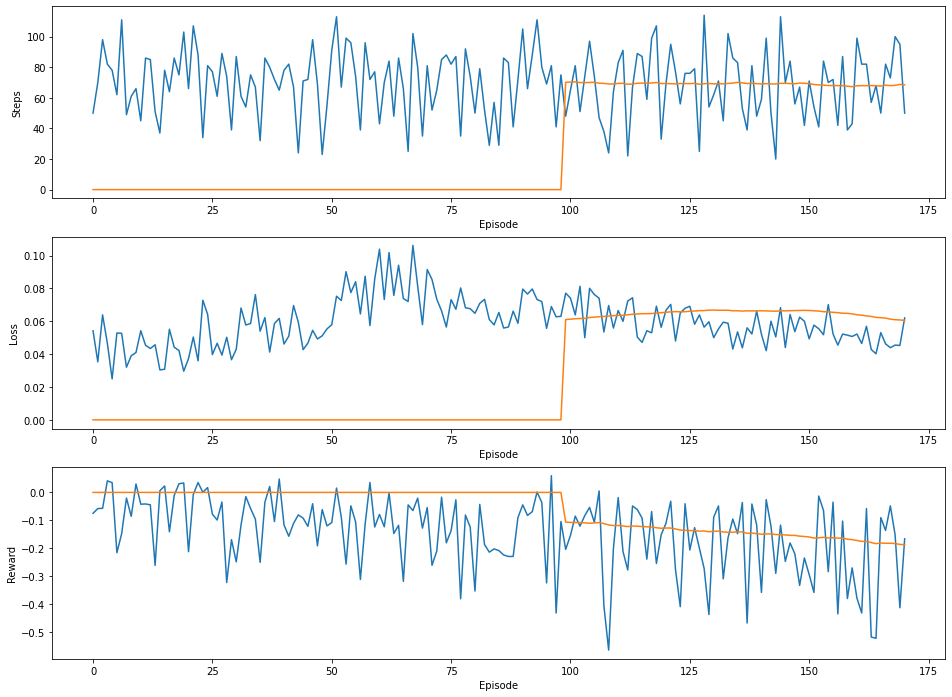

reward:  tensor([-0.1248], device='cuda:0')
reward:  tensor([-0.3982], device='cuda:0')
reward:  tensor([-0.5350], device='cuda:0')
reward:  tensor([-0.6479], device='cuda:0')
reward:  tensor([-0.5139], device='cuda:0')
reward:  tensor([0.1119], device='cuda:0')
reward:  tensor([-1.2080], device='cuda:0')
reward:  tensor([-1.2119], device='cuda:0')
reward:  tensor([-0.0899], device='cuda:0')
reward:  tensor([-0.8432], device='cuda:0')
CharterFlight(player=5, destination=36) 0.014959479790029095
DirectFlight(player=5, destination=44) 0.015959479790029096
DriveFerry(player=5, destination=16) 0.016959479790029094
DriveFerry(player=5, destination=44) 0.017959479790029095
OneQuietNight(player=5) 0.02591502984674798
Wait 0.02591502984674798
Wait 0.02591502984674798
DriveFerry(player=7, destination=10) 0.026915029846747977
DriveFerry(player=7, destination=31) 0.027915029846747978
DriveFerry(player=7, destination=48) 0.02891502984674798
DriveFerry(player=7, destination=29) 0.02991502984674798


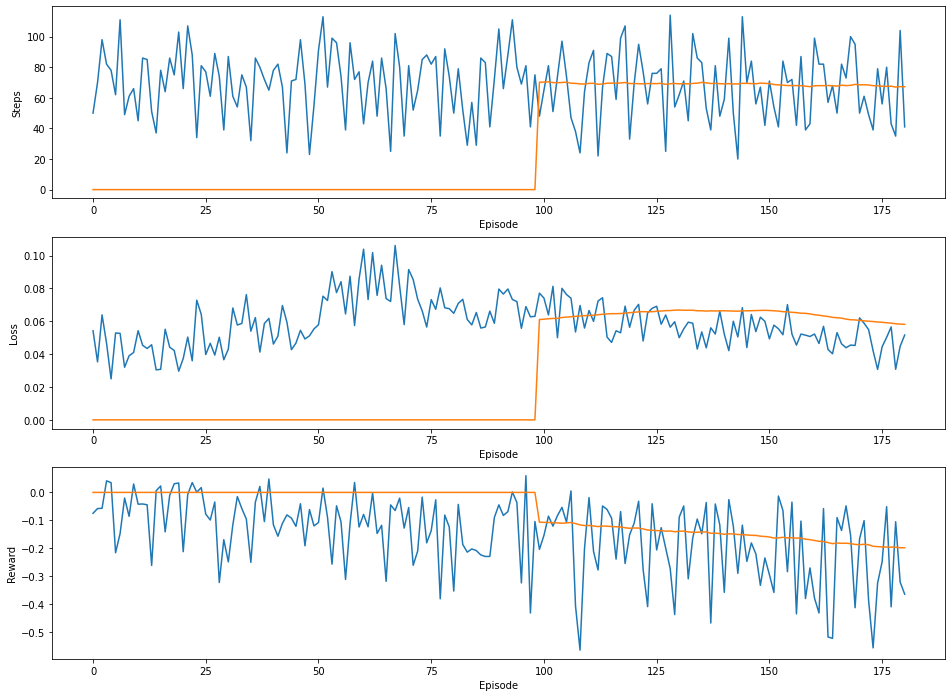

reward:  tensor([-0.9860], device='cuda:0')
reward:  tensor([-0.8181], device='cuda:0')
reward:  tensor([-0.8351], device='cuda:0')
reward:  tensor([-0.3643], device='cuda:0')
reward:  tensor([-1.0140], device='cuda:0')
reward:  tensor([-0.5649], device='cuda:0')
reward:  tensor([-0.8331], device='cuda:0')
reward:  tensor([-0.6639], device='cuda:0')
reward:  tensor([0.1180], device='cuda:0')
reward:  tensor([0.0900], device='cuda:0')
GovernmentGrant(player=5, target_city=16) 0.021866650170156654
DirectFlight(player=5, destination=37) 0.01591110011343777
DriveFerry(player=5, destination=18) 0.016911100113437768
DirectFlight(player=5, destination=15) 0.01791110011343777
DriveFerry(player=5, destination=30) 0.01891110011343777
Wait 0.025866650170156654
Wait 0.025866650170156654
Wait 0.025866650170156654
Wait 0.025866650170156654
DriveFerry(player=7, destination=48) 0.02686665017015665
CharterFlight(player=7, destination=13) 0.020911100113437768
DirectFlight(player=7, destination=8) 0.0149

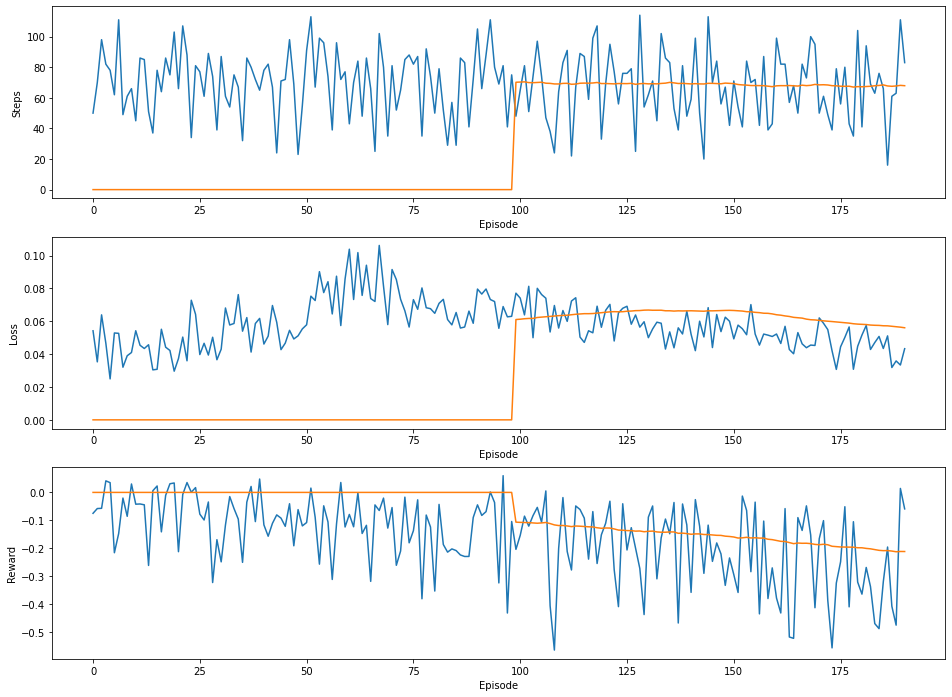

reward:  tensor([-0.8711], device='cuda:0')
reward:  tensor([-1.1690], device='cuda:0')
reward:  tensor([-0.8212], device='cuda:0')
reward:  tensor([0.1139], device='cuda:0')
reward:  tensor([-0.8150], device='cuda:0')
reward:  tensor([-0.3873], device='cuda:0')
reward:  tensor([-0.0021], device='cuda:0')
reward:  tensor([-0.9888], device='cuda:0')
reward:  tensor([-0.1980], device='cuda:0')
reward:  tensor([-1.0161], device='cuda:0')
DirectFlight(player=5, destination=21) 0.01491110011343777
DirectFlight(player=5, destination=30) 0.01591110011343777
DirectFlight(player=5, destination=23) 0.009955550056718884
DirectFlight(player=5, destination=40) 0.010955550056718884
Wait 0.010955550056718884
Wait 0.010955550056718884
Wait 0.010955550056718884
Wait 0.010955550056718884
DirectFlight(player=7, destination=44) 0.005
DriveFerry(player=7, destination=16) 0.006
DriveFerry(player=7, destination=44) 0.007
DriveFerry(player=7, destination=27) 0.008
Wait 0.014955550056718885
Wait 0.014955550056

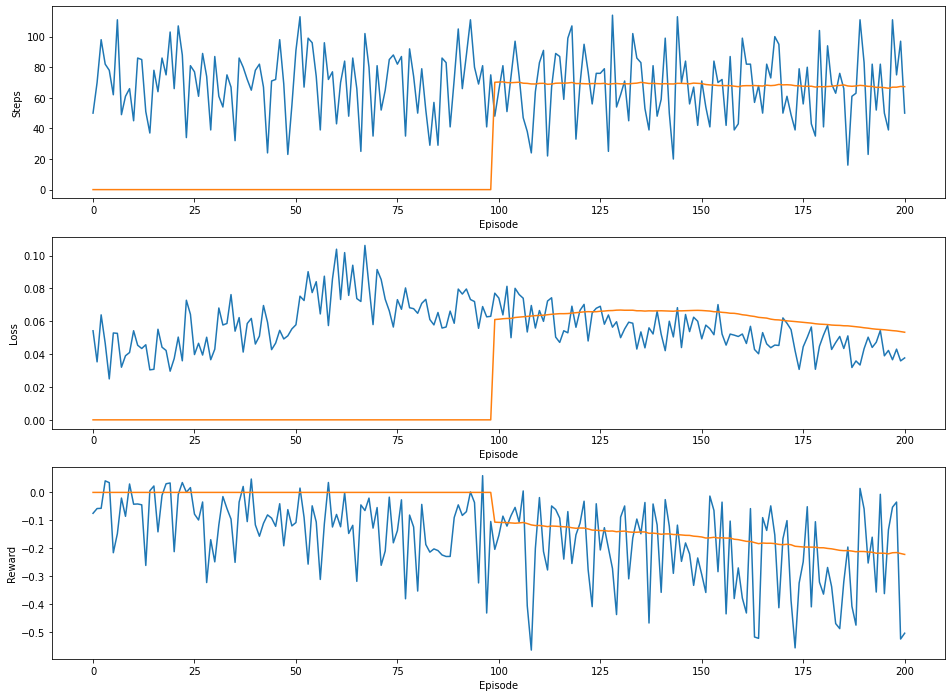

reward:  tensor([-0.0799], device='cuda:0')
reward:  tensor([-0.3732], device='cuda:0')
reward:  tensor([-0.3673], device='cuda:0')
reward:  tensor([-0.6639], device='cuda:0')
reward:  tensor([-0.7882], device='cuda:0')
reward:  tensor([-0.3443], device='cuda:0')
reward:  tensor([-0.4880], device='cuda:0')
reward:  tensor([-0.8152], device='cuda:0')
reward:  tensor([0.0919], device='cuda:0')
reward:  tensor([-0.5109], device='cuda:0')
DriveFerry(player=5, destination=29) 0.01491110011343777
BuildResearchStation(city=29) 0.008955550056718884
ShuttleFlight(player=5, destination=2) 0.009955550056718884
ShuttleFlight(player=5, destination=29) 0.010955550056718884
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
TreatDisease(city=2, target_virus=1) 0.01891110011343777
DirectFlight(player=7, destination=21) 0.019911100113437767
TreatDisease(city=21, target_virus=4) 0.020911100113437768
TreatDisease(city=21, target_virus=4) 0.0219111001134377

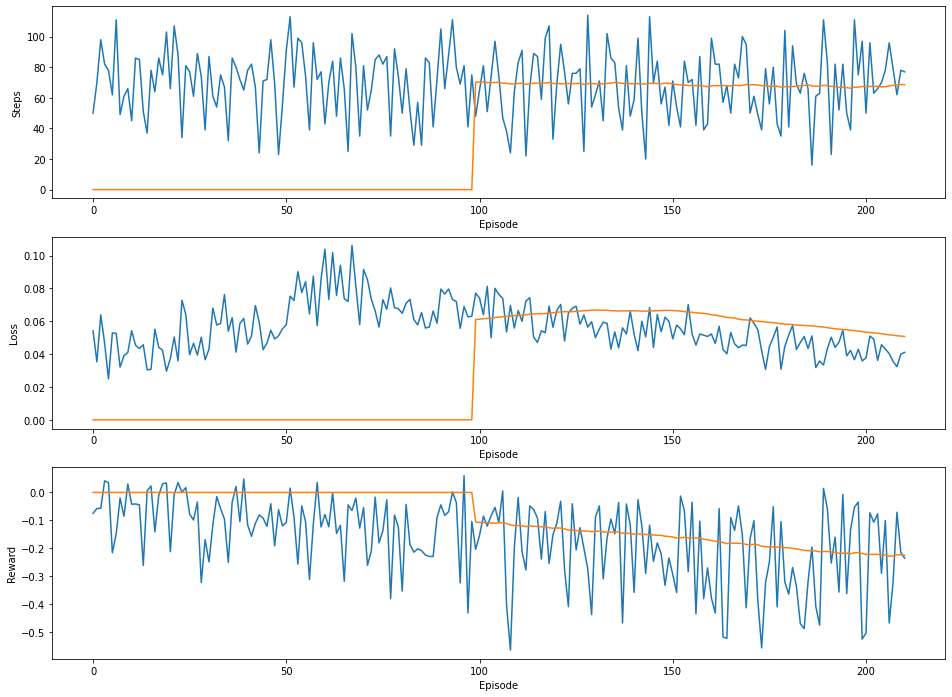

reward:  tensor([-0.6790], device='cuda:0')
reward:  tensor([-0.3612], device='cuda:0')
reward:  tensor([-0.6519], device='cuda:0')
reward:  tensor([-0.6519], device='cuda:0')
reward:  tensor([-0.8741], device='cuda:0')
reward:  tensor([-0.8820], device='cuda:0')
reward:  tensor([-0.8333], device='cuda:0')
reward:  tensor([-0.6768], device='cuda:0')
reward:  tensor([-0.1130], device='cuda:0')
reward:  tensor([-0.2270], device='cuda:0')
DirectFlight(player=5, destination=4) 0.007955550056718885
Airlift(player=5, target_player=7, destination=42) 0.008955550056718884
DriveFerry(player=5, destination=16) 0.009955550056718884
DriveFerry(player=5, destination=9) 0.010955550056718884
DriveFerry(player=5, destination=21) 0.011955550056718885
OneQuietNight(player=7) 0.019911100113437767
Wait 0.019911100113437767
Wait 0.019911100113437767
DirectFlight(player=7, destination=5) 0.020911100113437768
DriveFerry(player=7, destination=42) 0.02191110011343777
DirectFlight(player=7, destination=26) 0.01

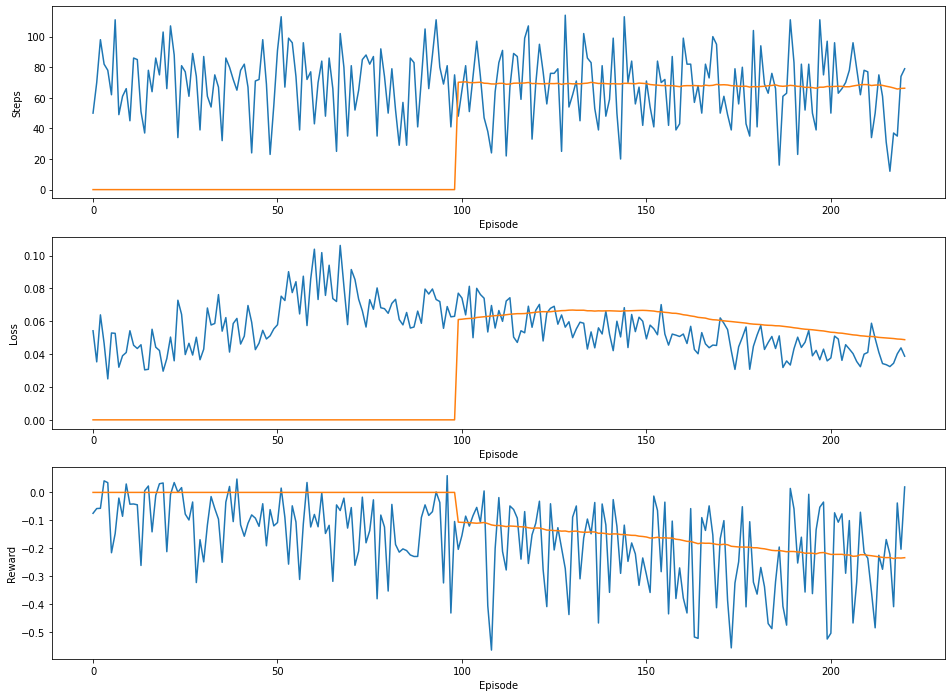

reward:  tensor([-0.7951], device='cuda:0')
reward:  tensor([-0.8132], device='cuda:0')
reward:  tensor([0.0930], device='cuda:0')
reward:  tensor([-0.6488], device='cuda:0')
reward:  tensor([0.0850], device='cuda:0')
reward:  tensor([-0.2040], device='cuda:0')
reward:  tensor([-0.8100], device='cuda:0')
reward:  tensor([-0.0231], device='cuda:0')
reward:  tensor([-0.8011], device='cuda:0')
reward:  tensor([-0.8182], device='cuda:0')
DriveFerry(player=5, destination=29) 0.01491110011343777
DirectFlight(player=5, destination=1) 0.008955550056718884
DirectFlight(player=5, destination=42) 0.003
DriveFerry(player=5, destination=47) 0.004
Wait 0.010955550056718884
Wait 0.010955550056718884
Wait 0.010955550056718884
Wait 0.010955550056718884
DriveFerry(player=7, destination=10) 0.011955550056718885
CharterFlight(player=7, destination=33) 0.012955550056718885
DriveFerry(player=7, destination=11) 0.013955550056718884
DriveFerry(player=7, destination=18) 0.014955550056718885
Wait 0.021911100113

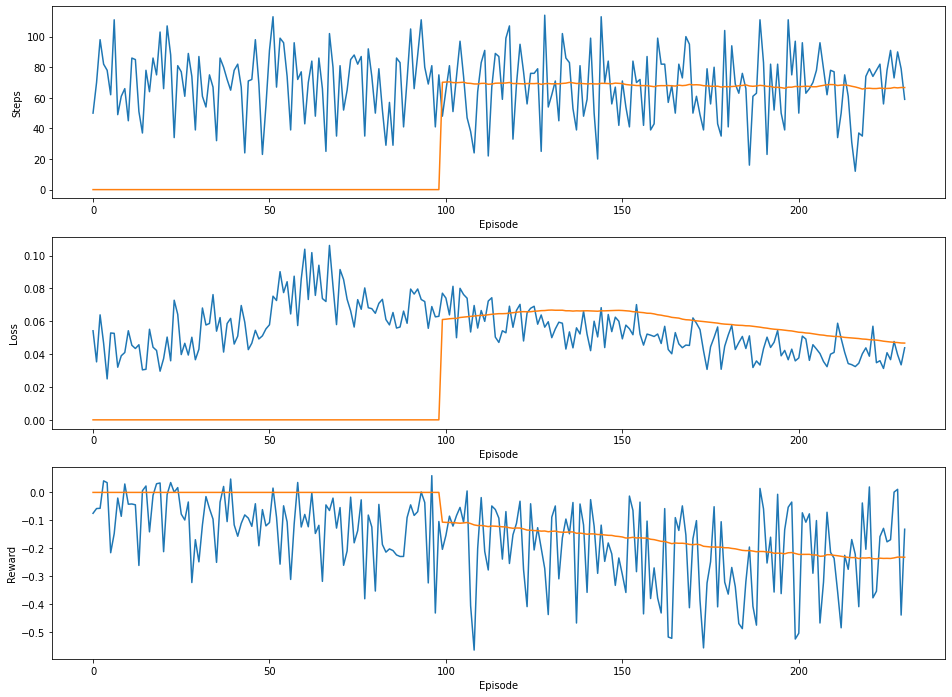

reward:  tensor([-0.9571], device='cuda:0')
reward:  tensor([-0.8122], device='cuda:0')
reward:  tensor([-0.8492], device='cuda:0')
reward:  tensor([-0.2560], device='cuda:0')
reward:  tensor([0.1088], device='cuda:0')
reward:  tensor([0.0909], device='cuda:0')
reward:  tensor([0.0860], device='cuda:0')
reward:  tensor([0.0108], device='cuda:0')
reward:  tensor([-0.7743], device='cuda:0')
reward:  tensor([0.1009], device='cuda:0')
DriveFerry(player=5, destination=29) 0.01491110011343777
DriveFerry(player=5, destination=28) 0.01591110011343777
DriveFerry(player=5, destination=10) 0.016911100113437768
Forecast(player=7) 0.01791110011343777
ChooseCard(player=5, card=35) 0.01891110011343777
ChooseCard(player=5, card=41) 0.019911100113437767
ChooseCard(player=5, card=15) 0.020911100113437768
ChooseCard(player=5, card=21) 0.02191110011343777
ChooseCard(player=5, card=23) 0.02291110011343777
ChooseCard(player=5, card=45) 0.02391110011343777
Wait 0.028002241994572456
Wait 0.028002241994572456


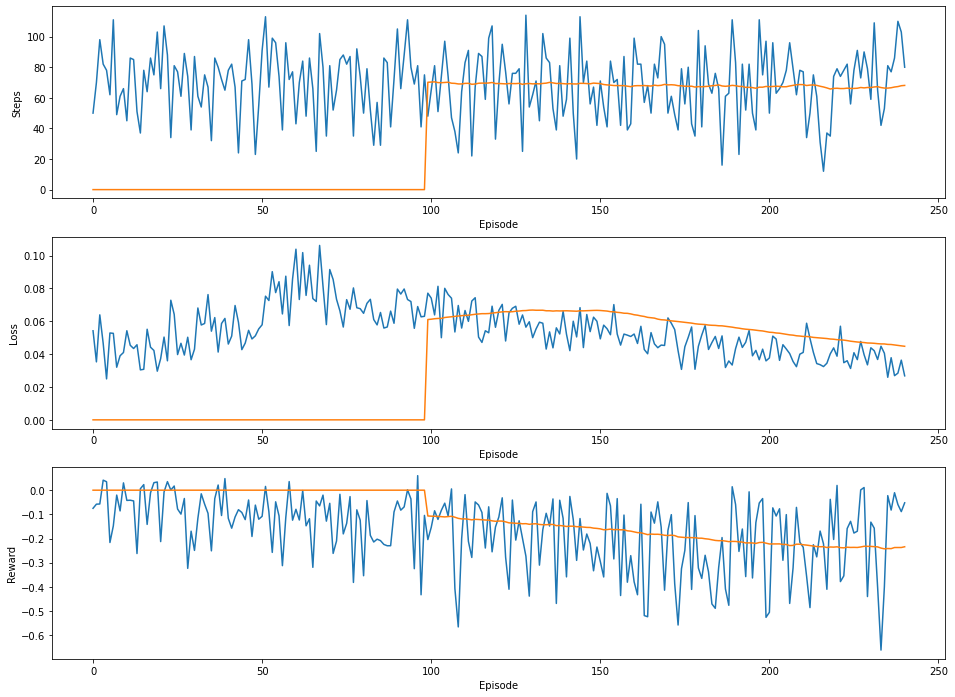

reward:  tensor([-0.9801], device='cuda:0')
reward:  tensor([-0.2130], device='cuda:0')
reward:  tensor([0.0959], device='cuda:0')
reward:  tensor([-0.2020], device='cuda:0')
reward:  tensor([-1.1800], device='cuda:0')
reward:  tensor([-0.8122], device='cuda:0')
reward:  tensor([-0.4968], device='cuda:0')
reward:  tensor([0.1010], device='cuda:0')
reward:  tensor([-0.5051], device='cuda:0')
reward:  tensor([-0.9780], device='cuda:0')
DriveFerry(player=5, destination=10) 0.01491110011343777
DriveFerry(player=5, destination=31) 0.01591110011343777
DriveFerry(player=5, destination=10) 0.016911100113437768
DriveFerry(player=5, destination=31) 0.01791110011343777
Wait 0.01791110011343777
Wait 0.024866650170156653
Wait 0.024866650170156653
Wait 0.024866650170156653
DirectFlight(player=7, destination=45) 0.025866650170156654
DriveFerry(player=7, destination=14) 0.02686665017015665
DriveFerry(player=7, destination=13) 0.027866650170156652
DirectFlight(player=7, destination=9) 0.028866650170156

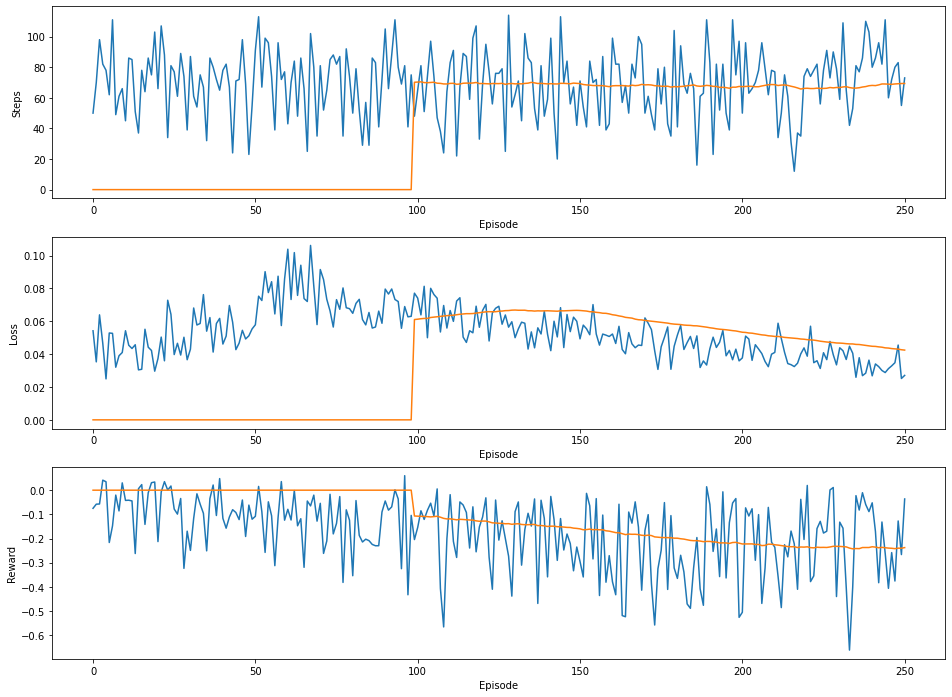

reward:  tensor([-0.0232], device='cuda:0')
reward:  tensor([-0.7953], device='cuda:0')
reward:  tensor([-0.5109], device='cuda:0')
reward:  tensor([-0.1119], device='cuda:0')
reward:  tensor([-0.3522], device='cuda:0')
reward:  tensor([-0.1089], device='cuda:0')
reward:  tensor([-0.4968], device='cuda:0')
reward:  tensor([-0.3592], device='cuda:0')
reward:  tensor([0.1010], device='cuda:0')
reward:  tensor([-0.2040], device='cuda:0')
DriveFerry(player=5, destination=10) 0.021866650170156654
DriveFerry(player=5, destination=31) 0.022866650170156655
DriveFerry(player=5, destination=10) 0.023866650170156652
DriveFerry(player=5, destination=31) 0.024866650170156653
Wait 0.02895779205129134
Wait 0.02895779205129134
Wait 0.02895779205129134
Wait 0.02895779205129134
DriveFerry(player=7, destination=48) 0.02995779205129134
DirectFlight(player=7, destination=35) 0.024002241994572453
DirectFlight(player=7, destination=45) 0.025002241994572454
DriveFerry(player=7, destination=35) 0.0260022419945

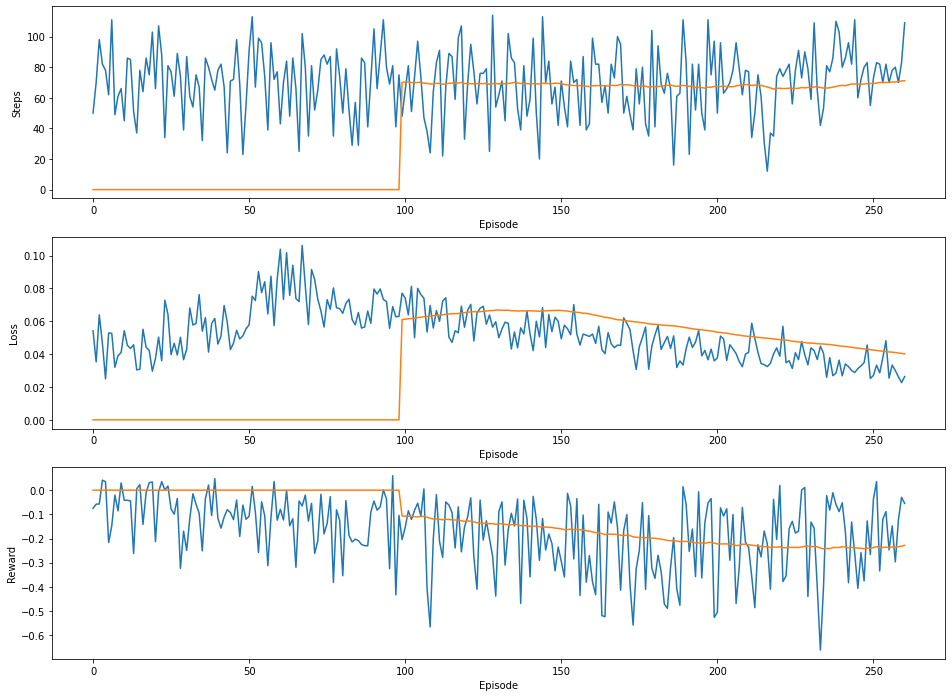

reward:  tensor([-0.3753], device='cuda:0')
reward:  tensor([-0.9990], device='cuda:0')
reward:  tensor([-0.8421], device='cuda:0')
reward:  tensor([-0.9770], device='cuda:0')
reward:  tensor([-0.8111], device='cuda:0')
reward:  tensor([-1.1840], device='cuda:0')
reward:  tensor([-1.0050], device='cuda:0')
reward:  tensor([-0.9611], device='cuda:0')
reward:  tensor([-0.6639], device='cuda:0')
reward:  tensor([-1.5768], device='cuda:0')
Airlift(player=5, target_player=7, destination=11) 0.019002241994572455
DirectFlight(player=5, destination=27) 0.020002241994572456
DirectFlight(player=5, destination=39) 0.01404669193785357
DirectFlight(player=5, destination=22) 0.01504669193785357
DriveFerry(player=5, destination=20) 0.01604669193785357
Wait 0.01604669193785357
Wait 0.023002241994572455
Wait 0.023002241994572455
Wait 0.023002241994572455
DriveFerry(player=7, destination=21) 0.024002241994572453
DriveFerry(player=7, destination=11) 0.025002241994572454
DriveFerry(player=7, destination=2

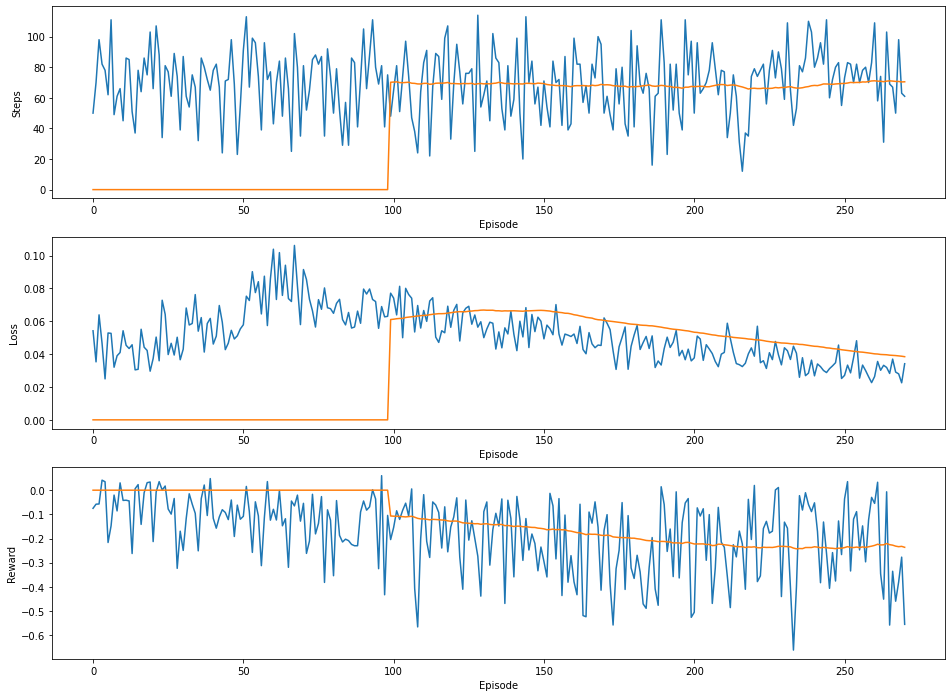

reward:  tensor([-0.0949], device='cuda:0')
reward:  tensor([0.0710], device='cuda:0')
reward:  tensor([-0.6489], device='cuda:0')
reward:  tensor([-0.8231], device='cuda:0')
reward:  tensor([0.0999], device='cuda:0')
reward:  tensor([-0.8442], device='cuda:0')
reward:  tensor([-0.7991], device='cuda:0')
reward:  tensor([-0.6479], device='cuda:0')
reward:  tensor([-0.9850], device='cuda:0')
reward:  tensor([-0.6328], device='cuda:0')
Airlift(player=5, target_player=7, destination=46) 0.02191502984674798
DirectFlight(player=5, destination=46) 0.02291502984674798
DriveFerry(player=5, destination=3) 0.023915029846747978
DriveFerry(player=5, destination=37) 0.02491502984674798
DriveFerry(player=5, destination=8) 0.02591502984674798
Wait 0.030006171727882665
Wait 0.030006171727882665
Wait 0.030006171727882665
Wait 0.030006171727882665
DriveFerry(player=7, destination=11) 0.031006171727882663
TreatDisease(city=11, target_virus=4) 0.032006171727882664
DriveFerry(player=7, destination=21) 0.03

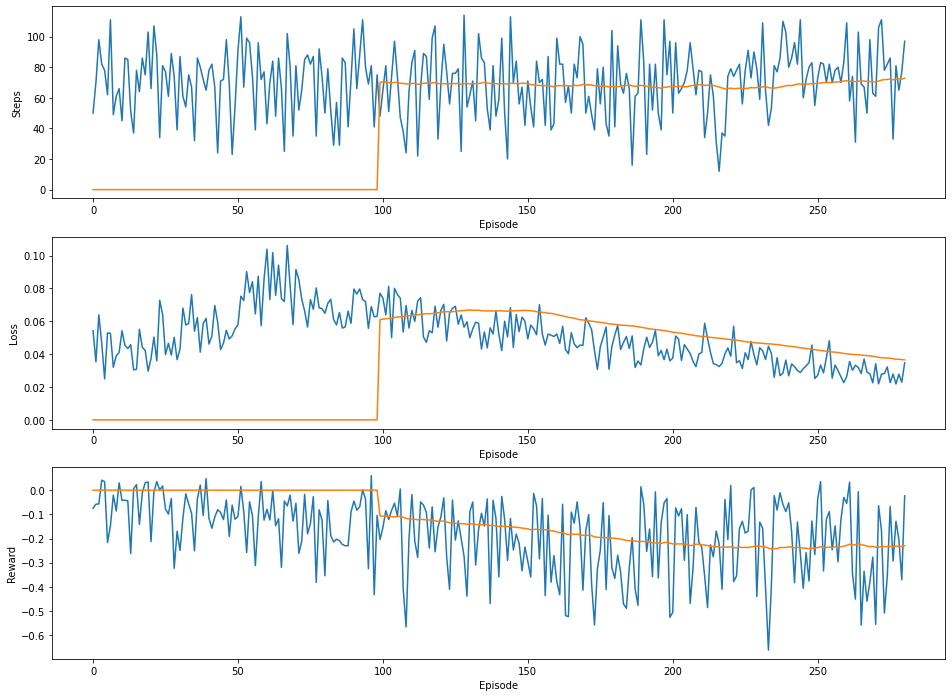

reward:  tensor([-0.8271], device='cuda:0')
reward:  tensor([-0.7089], device='cuda:0')
reward:  tensor([-0.0021], device='cuda:0')
reward:  tensor([-0.0869], device='cuda:0')
reward:  tensor([-0.7950], device='cuda:0')
reward:  tensor([-0.4760], device='cuda:0')
reward:  tensor([-0.8261], device='cuda:0')
reward:  tensor([-1.0260], device='cuda:0')
reward:  tensor([0.0620], device='cuda:0')
reward:  tensor([-1.0200], device='cuda:0')
ShareKnowledge(player=7, card=2, target_player=5) 0.007955550056718885
CharterFlight(player=5, destination=42) 0.008955550056718884
DirectFlight(player=5, destination=3) 0.009955550056718884
DirectFlight(player=5, destination=27) 0.010955550056718884
OneQuietNight(player=5) 0.011955550056718885
Forecast(player=5) 0.012955550056718885
ChooseCard(player=5, card=26) 0.013955550056718884
ChooseCard(player=5, card=12) 0.014955550056718885
ChooseCard(player=5, card=17) 0.015955550056718885
ChooseCard(player=5, card=18) 0.016955550056718886
ChooseCard(player=5, 

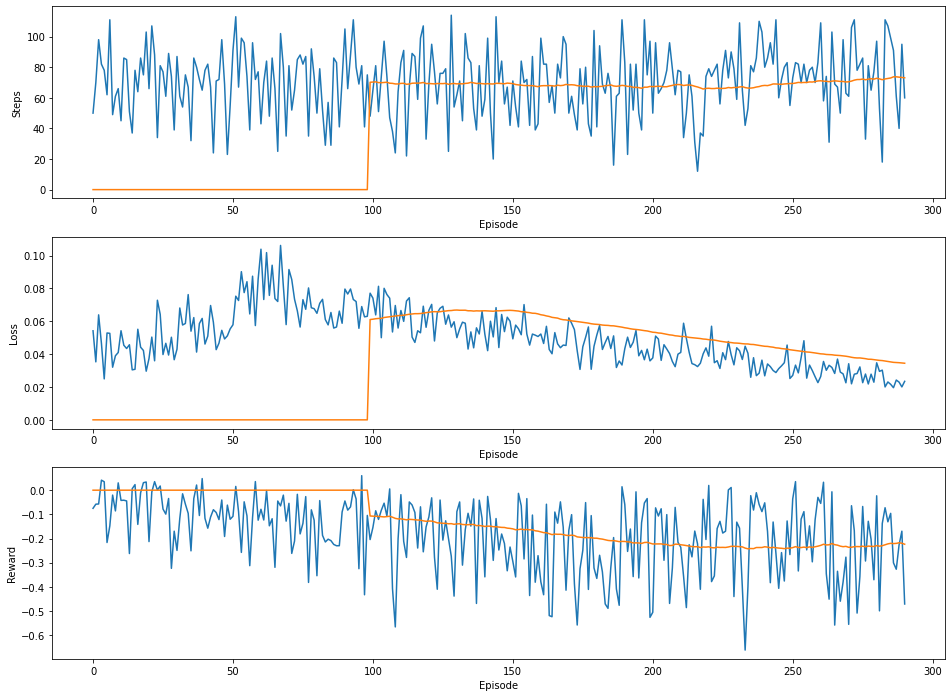

reward:  tensor([-1.4214], device='cuda:0')
reward:  tensor([-0.5080], device='cuda:0')
reward:  tensor([-0.2761], device='cuda:0')
reward:  tensor([-0.4243], device='cuda:0')
reward:  tensor([-0.7962], device='cuda:0')
reward:  tensor([-0.2270], device='cuda:0')
reward:  tensor([-0.0899], device='cuda:0')
reward:  tensor([-0.8052], device='cuda:0')
reward:  tensor([-0.8152], device='cuda:0')
reward:  tensor([-0.3613], device='cuda:0')
CharterFlight(player=5, destination=41) 0.007955550056718885
DirectFlight(player=5, destination=32) 0.008955550056718884
DriveFerry(player=5, destination=43) 0.009955550056718884
DirectFlight(player=5, destination=42) 0.004
Wait 0.004
Wait 0.004
Wait 0.004
GovernmentGrant(player=5, target_city=13) 0.005
Wait -0.035
DirectFlight(player=7, destination=35) -0.034
DirectFlight(player=7, destination=33) -0.033
DriveFerry(player=7, destination=18) -0.032
DriveFerry(player=7, destination=33) -0.031
Wait -0.031
Wait -0.031
Wait -0.031
Wait -0.031
DirectFlight(pl

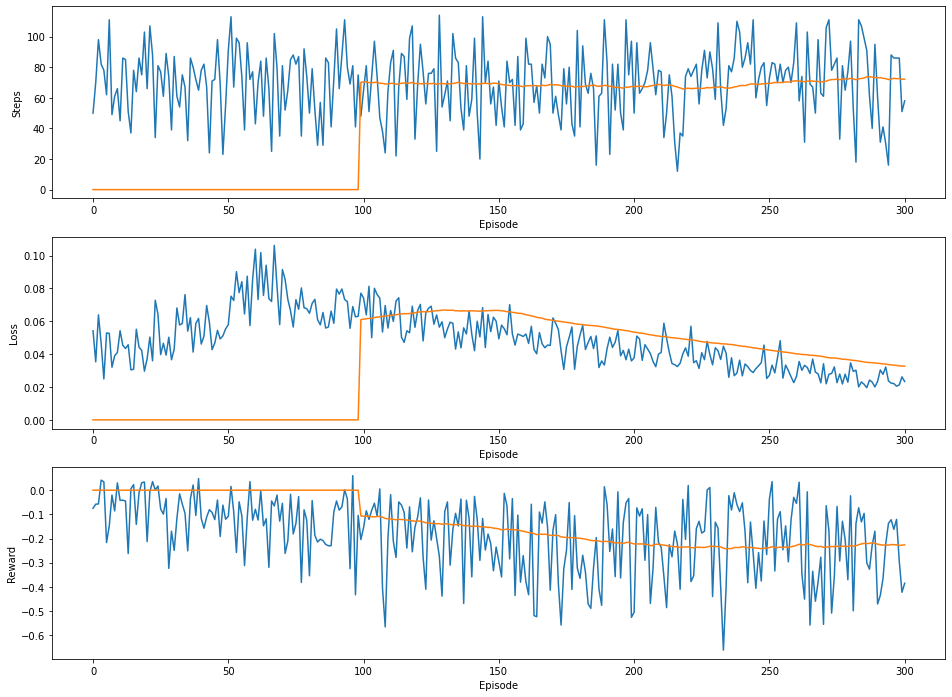

reward:  tensor([-0.6639], device='cuda:0')
reward:  tensor([-0.9810], device='cuda:0')
reward:  tensor([-0.3343], device='cuda:0')
reward:  tensor([-0.8631], device='cuda:0')
reward:  tensor([0.0949], device='cuda:0')
reward:  tensor([-0.8332], device='cuda:0')
reward:  tensor([-0.1388], device='cuda:0')
reward:  tensor([0.0889], device='cuda:0')
reward:  tensor([0.0810], device='cuda:0')
reward:  tensor([-0.5239], device='cuda:0')
Airlift(player=5, target_player=5, destination=17) 0.01491110011343777
DirectFlight(player=5, destination=15) 0.008955550056718884
DirectFlight(player=5, destination=32) 0.009955550056718884
DriveFerry(player=5, destination=15) 0.010955550056718884
DirectFlight(player=5, destination=5) 0.011955550056718885
ResilientPopulation(player=7, discard_city=8) 0.012955550056718885
Wait 0.012955550056718885
Wait 0.012955550056718885
Wait 0.012955550056718885
DirectFlight(player=7, destination=26) 0.007
DirectFlight(player=7, destination=10) 0.008
DriveFerry(player=7,

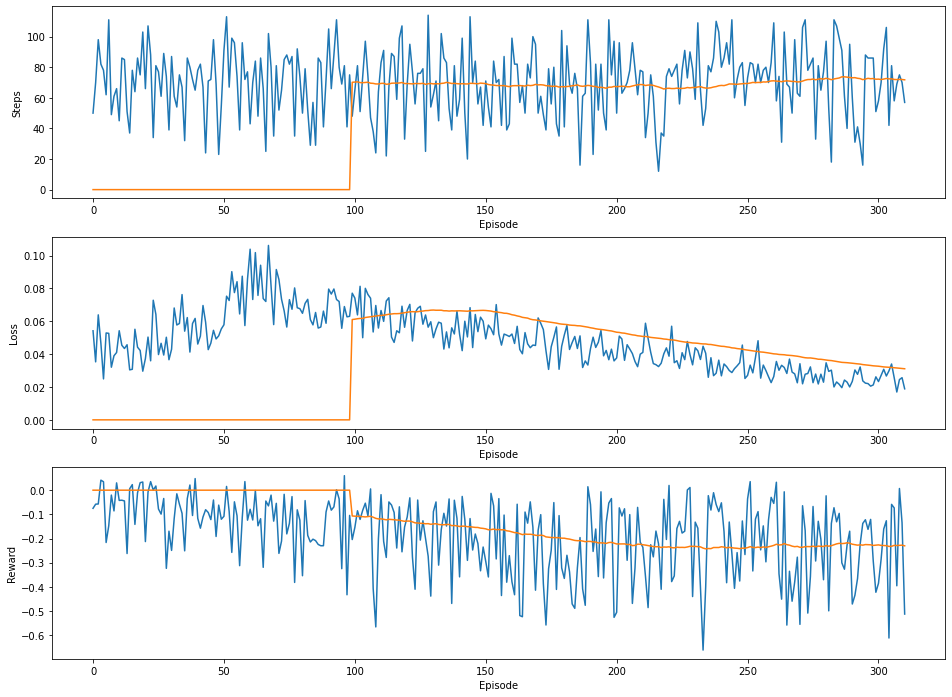

reward:  tensor([-0.2020], device='cuda:0')
reward:  tensor([-0.8692], device='cuda:0')
reward:  tensor([-0.8101], device='cuda:0')
reward:  tensor([0.0810], device='cuda:0')
reward:  tensor([-0.8811], device='cuda:0')
reward:  tensor([-0.9900], device='cuda:0')
reward:  tensor([-0.4899], device='cuda:0')
reward:  tensor([-0.4979], device='cuda:0')
reward:  tensor([-0.3572], device='cuda:0')
reward:  tensor([-0.8321], device='cuda:0')
DirectFlight(player=5, destination=4) 0.01491110011343777
DirectFlight(player=5, destination=28) 0.008955550056718884
DriveFerry(player=5, destination=23) 0.009955550056718884
DirectFlight(player=5, destination=7) 0.010955550056718884
ResilientPopulation(player=5, discard_city=25) 0.011955550056718885
Wait 0.011955550056718885
OneQuietNight(player=5) 0.012955550056718885
DirectFlight(player=7, destination=24) 0.007
DirectFlight(player=7, destination=1) 0.008
DirectFlight(player=7, destination=5) 0.009000000000000001
DriveFerry(player=7, destination=42) 0.

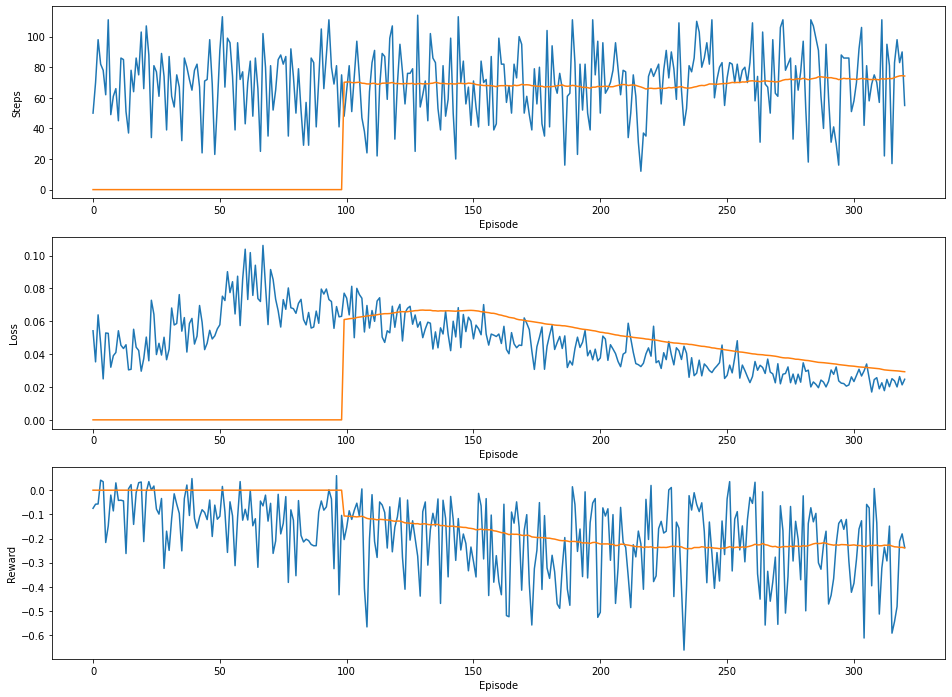

reward:  tensor([-0.0353], device='cuda:0')
reward:  tensor([-0.8082], device='cuda:0')
reward:  tensor([-0.4949], device='cuda:0')
reward:  tensor([-0.0799], device='cuda:0')
reward:  tensor([-0.1069], device='cuda:0')
reward:  tensor([-0.4003], device='cuda:0')
reward:  tensor([-1.3693], device='cuda:0')
reward:  tensor([-0.0372], device='cuda:0')
reward:  tensor([-0.4960], device='cuda:0')
reward:  tensor([0.0810], device='cuda:0')
DirectFlight(player=5, destination=25) 0.007955550056718885
DirectFlight(player=5, destination=28) 0.008955550056718884
DirectFlight(player=5, destination=34) 0.009955550056718884
DriveFerry(player=5, destination=26) 0.010955550056718884
OneQuietNight(player=5) 0.011955550056718885
Wait 0.011955550056718885
Wait 0.011955550056718885
DirectFlight(player=7, destination=31) 0.006
DriveFerry(player=7, destination=48) 0.007
DriveFerry(player=7, destination=34) 0.008
DirectFlight(player=7, destination=19) 0.009000000000000001
Wait 0.009000000000000001
Wait 0.01

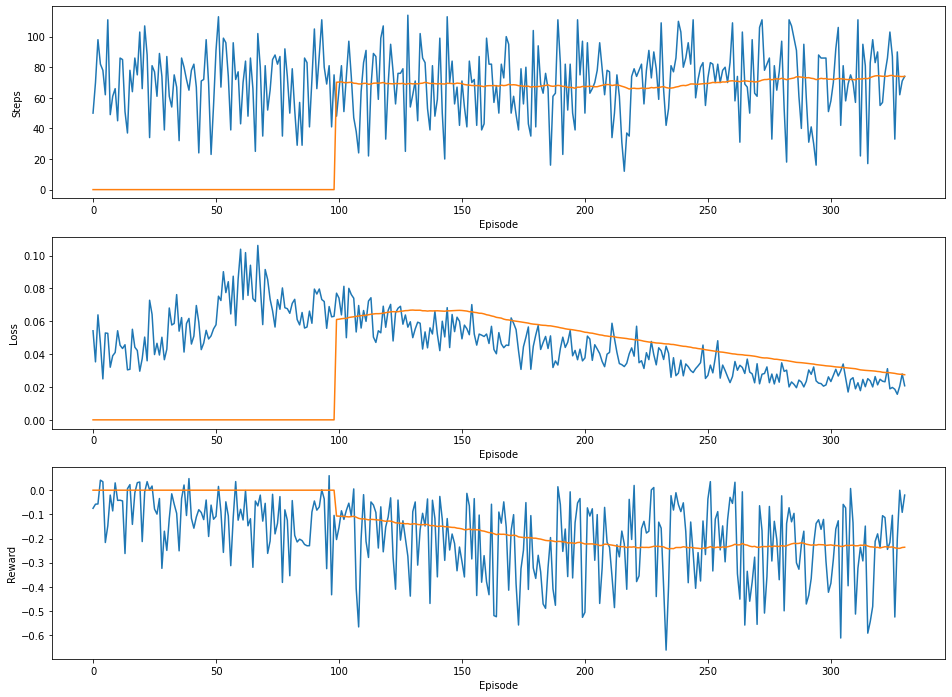

reward:  tensor([0.0790], device='cuda:0')
reward:  tensor([0.0890], device='cuda:0')
reward:  tensor([-0.2320], device='cuda:0')
reward:  tensor([0.0980], device='cuda:0')
reward:  tensor([-0.8372], device='cuda:0')
reward:  tensor([0.0930], device='cuda:0')
reward:  tensor([-0.1109], device='cuda:0')
reward:  tensor([-0.4618], device='cuda:0')
reward:  tensor([-0.8339], device='cuda:0')
reward:  tensor([-0.8210], device='cuda:0')
DirectFlight(player=5, destination=16) 0.001
DirectFlight(player=5, destination=25) 0.002
ResilientPopulation(player=7, discard_city=39) 0.003
DriveFerry(player=5, destination=38) 0.004
DriveFerry(player=5, destination=27) 0.005
Wait 0.005
Wait 0.011955550056718885
Wait 0.011955550056718885
Wait 0.011955550056718885
DriveFerry(player=7, destination=29) 0.012955550056718885
TreatDisease(city=29, target_virus=3) 0.013955550056718884
DriveFerry(player=7, destination=28) 0.014955550056718885
DirectFlight(player=7, destination=13) 0.015955550056718885
Wait 0.0229

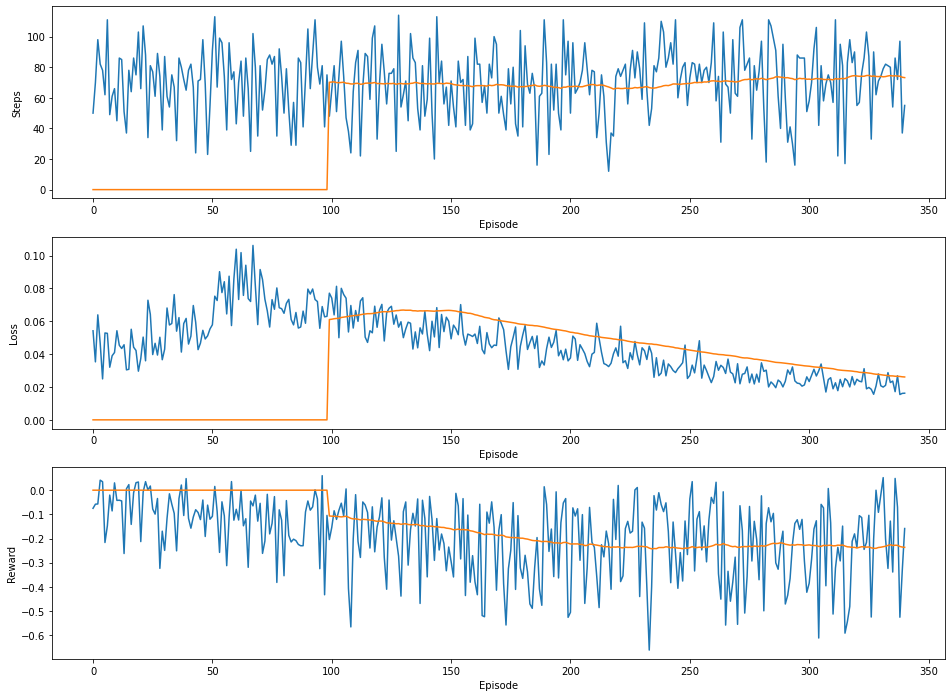

reward:  tensor([-0.8222], device='cuda:0')
reward:  tensor([-0.8053], device='cuda:0')
reward:  tensor([-0.8312], device='cuda:0')
reward:  tensor([-0.1178], device='cuda:0')
reward:  tensor([-0.5250], device='cuda:0')
reward:  tensor([-0.8161], device='cuda:0')
reward:  tensor([-0.2081], device='cuda:0')
reward:  tensor([-0.1961], device='cuda:0')
reward:  tensor([-0.1248], device='cuda:0')
reward:  tensor([0.1180], device='cuda:0')
CharterFlight(player=5, destination=16) 0.01491110011343777
DriveFerry(player=5, destination=44) 0.01591110011343777
DirectFlight(player=5, destination=34) 0.016911100113437768
DriveFerry(player=5, destination=26) 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
Forecast(player=5) 0.01891110011343777
ChooseCard(player=5, card=43) 0.019911100113437767
ChooseCard(player=5, card=35) 0.020911100113437768
ChooseCard(player=5, card=25) 0.02191110011343777
ChooseCard(player=5, card=11) 0.02291110011343777
ChooseCard(player=5, card=28) 0.0239

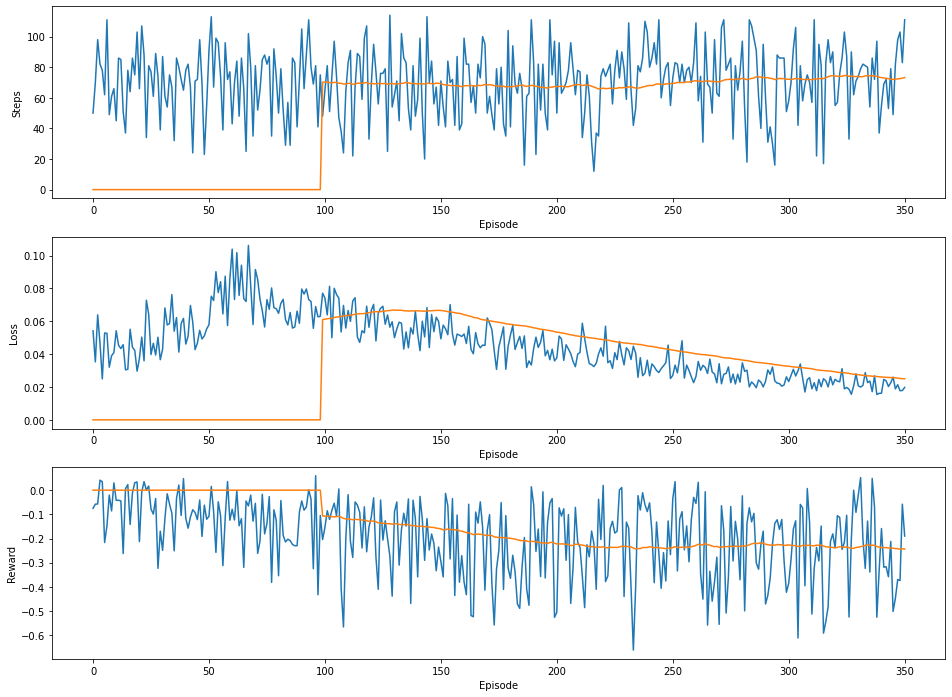

reward:  tensor([-1.2270], device='cuda:0')
reward:  tensor([-0.9642], device='cuda:0')
reward:  tensor([0.0820], device='cuda:0')
reward:  tensor([-0.5079], device='cuda:0')
reward:  tensor([-0.7912], device='cuda:0')
reward:  tensor([-0.6249], device='cuda:0')
reward:  tensor([-0.5080], device='cuda:0')
reward:  tensor([-0.2501], device='cuda:0')
reward:  tensor([0.0820], device='cuda:0')
reward:  tensor([0.0940], device='cuda:0')
DriveFerry(player=5, destination=48) 0.019002241994572455
GovernmentGrant(player=5, target_city=16) 0.020002241994572456
DriveFerry(player=5, destination=34) 0.021002241994572454
DirectFlight(player=5, destination=41) 0.01791110011343777
DriveFerry(player=5, destination=42) 0.01891110011343777
Wait 0.01891110011343777
Wait 0.01891110011343777
Wait 0.01891110011343777
Wait 0.01891110011343777
ShuttleFlight(player=7, destination=16) 0.019911100113437767
DirectFlight(player=7, destination=25) 0.020911100113437768
DriveFerry(player=7, destination=44) 0.02191110

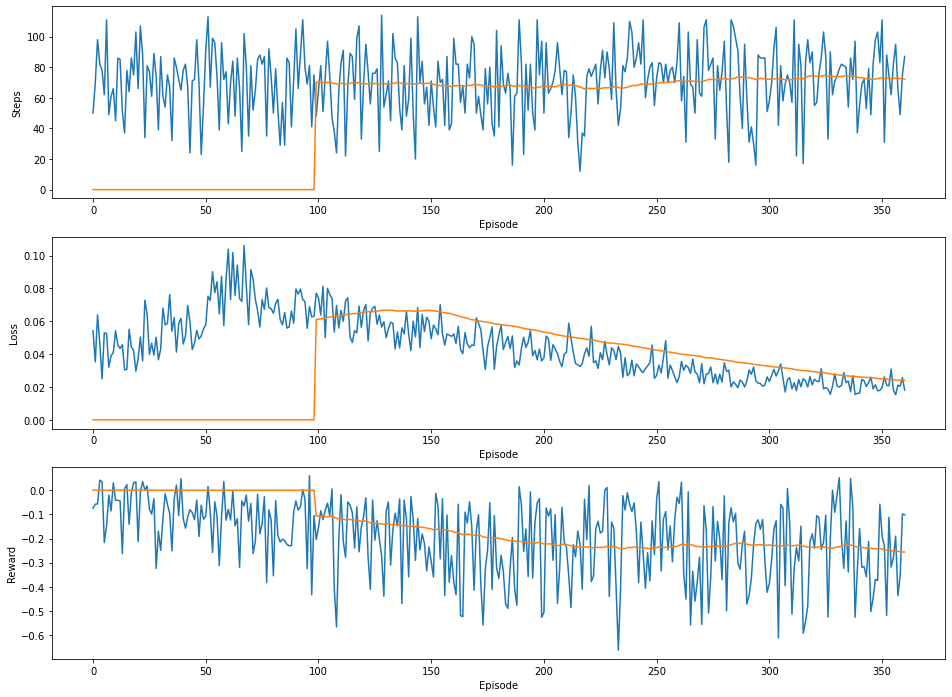

reward:  tensor([-1.2040], device='cuda:0')
reward:  tensor([-0.0271], device='cuda:0')
reward:  tensor([0.0890], device='cuda:0')
reward:  tensor([-0.4960], device='cuda:0')
reward:  tensor([-0.9750], device='cuda:0')
reward:  tensor([-0.4839], device='cuda:0')
reward:  tensor([-0.4033], device='cuda:0')
reward:  tensor([-0.9960], device='cuda:0')
reward:  tensor([-0.8431], device='cuda:0')
reward:  tensor([0.0979], device='cuda:0')
DirectFlight(player=5, destination=47) 0.01491110011343777
DriveFerry(player=5, destination=41) 0.01591110011343777
DriveFerry(player=5, destination=42) 0.016911100113437768
DriveFerry(player=5, destination=41) 0.01791110011343777
GovernmentGrant(player=7, target_city=13) 0.025866650170156654
Wait 0.025866650170156654
Wait 0.025866650170156654
Wait 0.025866650170156654
DriveFerry(player=7, destination=48) 0.02686665017015665
DriveFerry(player=7, destination=34) 0.027866650170156652
DirectFlight(player=7, destination=45) 0.02191110011343777
DriveFerry(playe

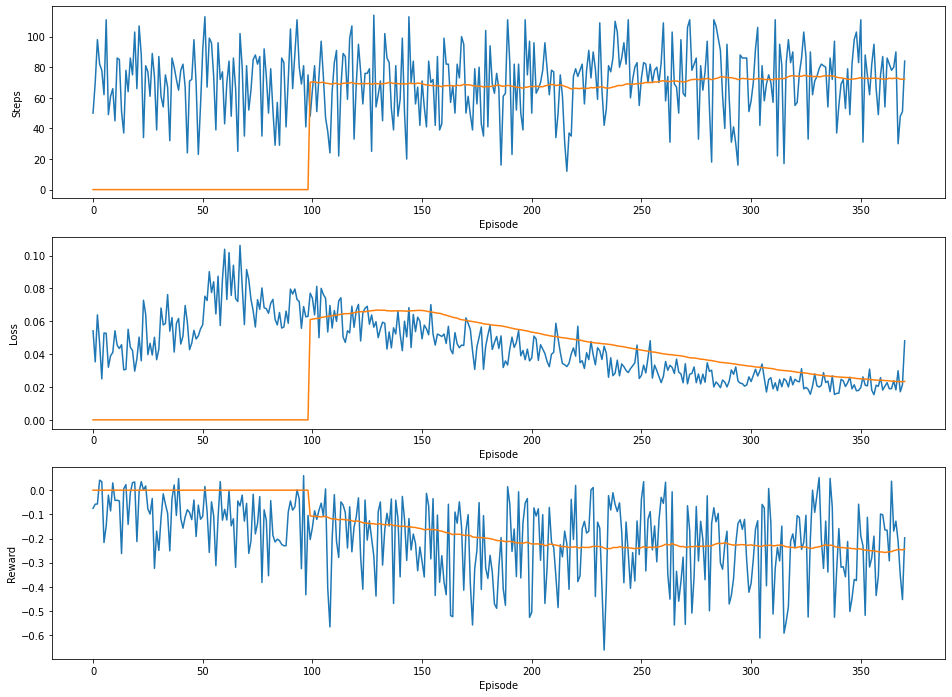

reward:  tensor([-0.1120], device='cuda:0')
reward:  tensor([-0.8401], device='cuda:0')
reward:  tensor([-0.2893], device='cuda:0')
reward:  tensor([-0.6430], device='cuda:0')
reward:  tensor([-1.0348], device='cuda:0')
reward:  tensor([-0.6659], device='cuda:0')
reward:  tensor([-1.0091], device='cuda:0')
reward:  tensor([0.0969], device='cuda:0')
reward:  tensor([-0.7752], device='cuda:0')
reward:  tensor([-0.8211], device='cuda:0')
GovernmentGrant(player=7, target_city=16) 0.007955550056718885
DriveFerry(player=5, destination=29) 0.008955550056718884
DriveFerry(player=5, destination=28) 0.009955550056718884
DriveFerry(player=5, destination=23) 0.010955550056718884
DriveFerry(player=5, destination=39) 0.011955550056718885
OneQuietNight(player=7) 0.019911100113437767
Wait 0.02686665017015665
Wait 0.02686665017015665
ShuttleFlight(player=7, destination=16) 0.027866650170156652
ShuttleFlight(player=7, destination=2) 0.028866650170156653
ShuttleFlight(player=7, destination=16) 0.02986665

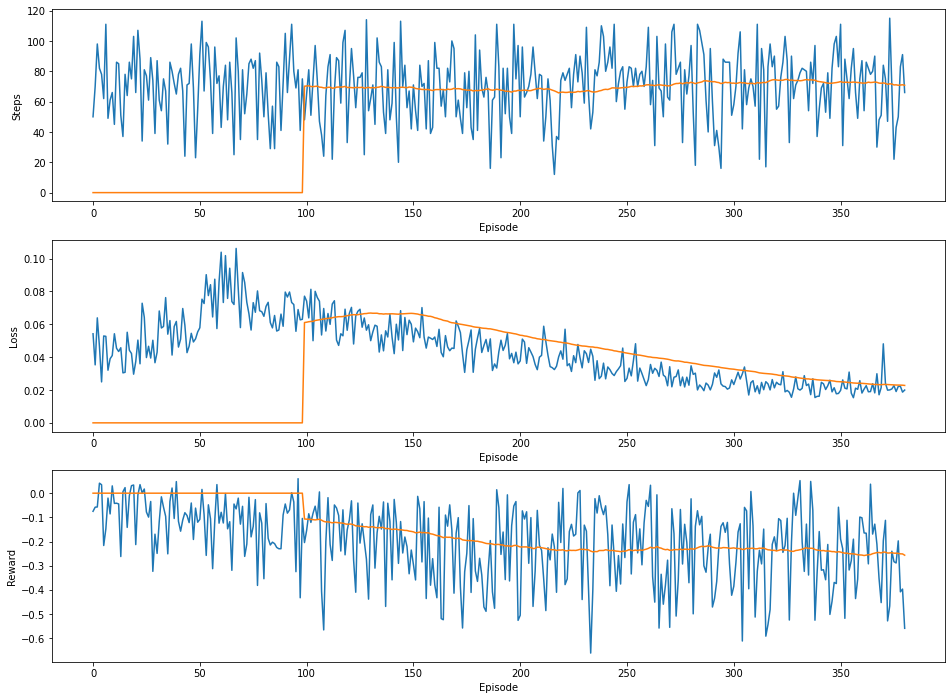

reward:  tensor([-0.2040], device='cuda:0')
reward:  tensor([-1.0051], device='cuda:0')
reward:  tensor([-0.1248], device='cuda:0')
reward:  tensor([-0.8530], device='cuda:0')
reward:  tensor([-0.6318], device='cuda:0')
reward:  tensor([-0.1309], device='cuda:0')
reward:  tensor([-0.1029], device='cuda:0')
reward:  tensor([-0.9462], device='cuda:0')
reward:  tensor([-1.2121], device='cuda:0')
reward:  tensor([-0.2790], device='cuda:0')
DriveFerry(player=5, destination=10) 0.007955550056718885
DriveFerry(player=5, destination=38) 0.008955550056718884
DirectFlight(player=5, destination=12) 0.009955550056718884
DriveFerry(player=5, destination=43) 0.010955550056718884
Wait 0.010955550056718884
Wait 0.01504669193785357
Wait 0.01504669193785357
Wait 0.01504669193785357
DriveFerry(player=7, destination=10) 0.01604669193785357
DriveFerry(player=7, destination=38) 0.01704669193785357
DriveFerry(player=7, destination=10) 0.01804669193785357
DriveFerry(player=7, destination=38) 0.019046691937853

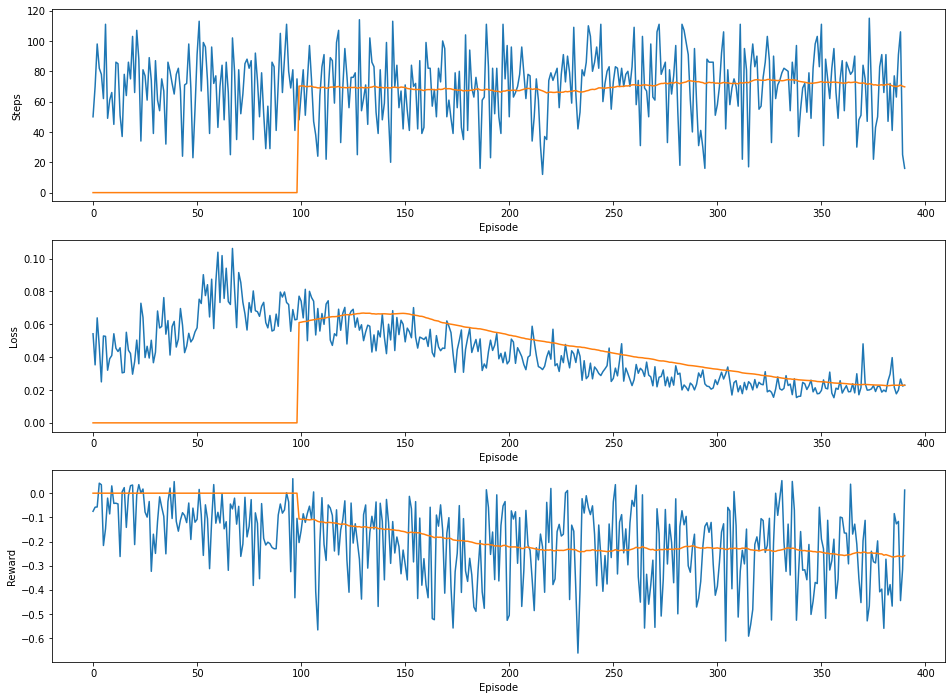

reward:  tensor([-0.6618], device='cuda:0')
reward:  tensor([-0.2130], device='cuda:0')
reward:  tensor([0.0900], device='cuda:0')
reward:  tensor([-0.3912], device='cuda:0')
reward:  tensor([-0.6299], device='cuda:0')
reward:  tensor([0.0870], device='cuda:0')
reward:  tensor([-1.0070], device='cuda:0')
reward:  tensor([-0.0242], device='cuda:0')
reward:  tensor([-0.9500], device='cuda:0')
reward:  tensor([-0.8181], device='cuda:0')
Forecast(player=7) 0.01491110011343777
ChooseCard(player=5, card=4) 0.01591110011343777
ChooseCard(player=5, card=38) 0.016911100113437768
ChooseCard(player=5, card=25) 0.01791110011343777
ChooseCard(player=5, card=35) 0.01891110011343777
ChooseCard(player=5, card=31) 0.019911100113437767
ChooseCard(player=5, card=12) 0.020911100113437768
DriveFerry(player=5, destination=10) 0.02191110011343777
DriveFerry(player=5, destination=38) 0.02291110011343777
DriveFerry(player=5, destination=10) 0.02391110011343777
Wait 0.030866650170156655
Wait 0.03495779205129134

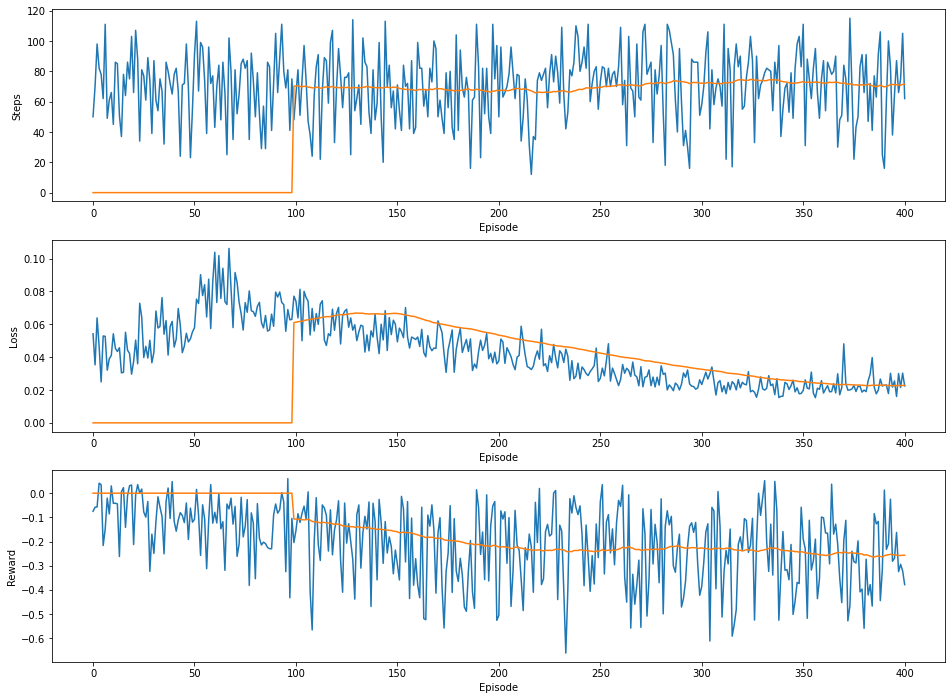

reward:  tensor([0.1120], device='cuda:0')
reward:  tensor([-0.0979], device='cuda:0')
reward:  tensor([-0.8151], device='cuda:0')
reward:  tensor([-0.2340], device='cuda:0')
reward:  tensor([-0.7942], device='cuda:0')
reward:  tensor([-1.0291], device='cuda:0')
reward:  tensor([-0.4720], device='cuda:0')
reward:  tensor([-1.1820], device='cuda:0')
reward:  tensor([-0.6179], device='cuda:0')
reward:  tensor([-0.8162], device='cuda:0')
GovernmentGrant(player=5, target_city=5) 0.019002241994572455
DirectFlight(player=5, destination=27) 0.01591110011343777
DirectFlight(player=5, destination=47) 0.009955550056718884
DriveFerry(player=5, destination=35) 0.010955550056718884
DirectFlight(player=5, destination=14) 0.011955550056718885
Wait 0.011955550056718885
Wait 0.011955550056718885
Wait 0.011955550056718885
Wait 0.011955550056718885
DriveFerry(player=7, destination=48) 0.012955550056718885
DriveFerry(player=7, destination=34) 0.013955550056718884
CharterFlight(player=7, destination=46) 0.

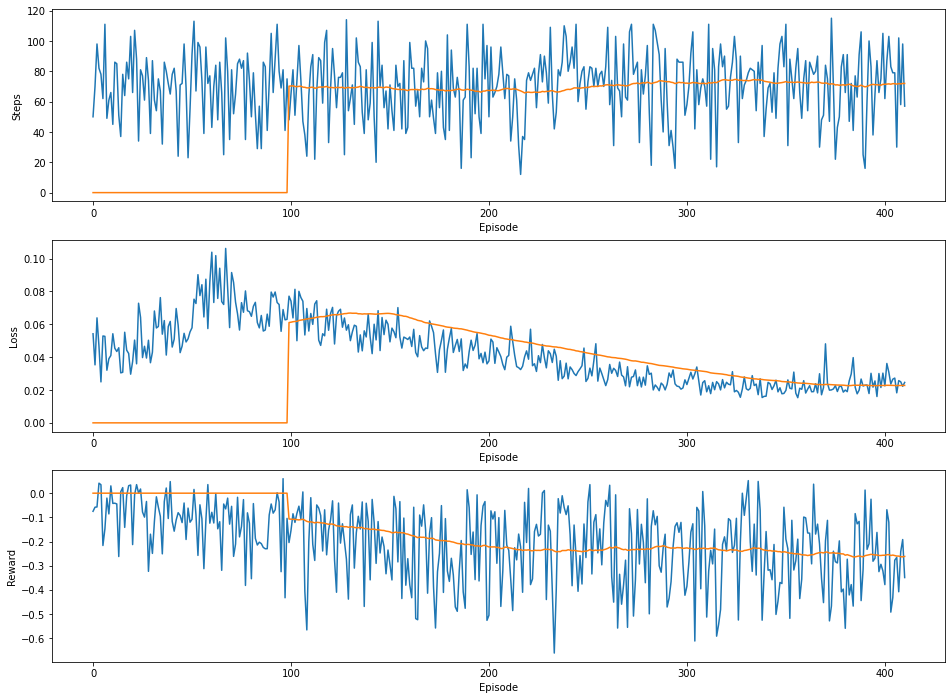

reward:  tensor([-0.7912], device='cuda:0')
reward:  tensor([-0.4650], device='cuda:0')
reward:  tensor([0.1180], device='cuda:0')
reward:  tensor([-0.8151], device='cuda:0')
reward:  tensor([-0.8421], device='cuda:0')
reward:  tensor([-0.2090], device='cuda:0')
reward:  tensor([-0.5090], device='cuda:0')
reward:  tensor([-0.7991], device='cuda:0')
reward:  tensor([0.0599], device='cuda:0')
reward:  tensor([-0.9651], device='cuda:0')
DriveFerry(player=5, destination=10) 0.021866650170156654
DriveFerry(player=5, destination=38) 0.022866650170156655
DriveFerry(player=5, destination=10) 0.023866650170156652
DriveFerry(player=5, destination=38) 0.024866650170156653
Forecast(player=7) 0.025866650170156654
ChooseCard(player=5, card=5) 0.02686665017015665
ChooseCard(player=5, card=32) 0.027866650170156652
ChooseCard(player=5, card=9) 0.028866650170156653
ChooseCard(player=5, card=38) 0.029866650170156654
ChooseCard(player=5, card=28) 0.030866650170156655
ChooseCard(player=5, card=47) 0.035957

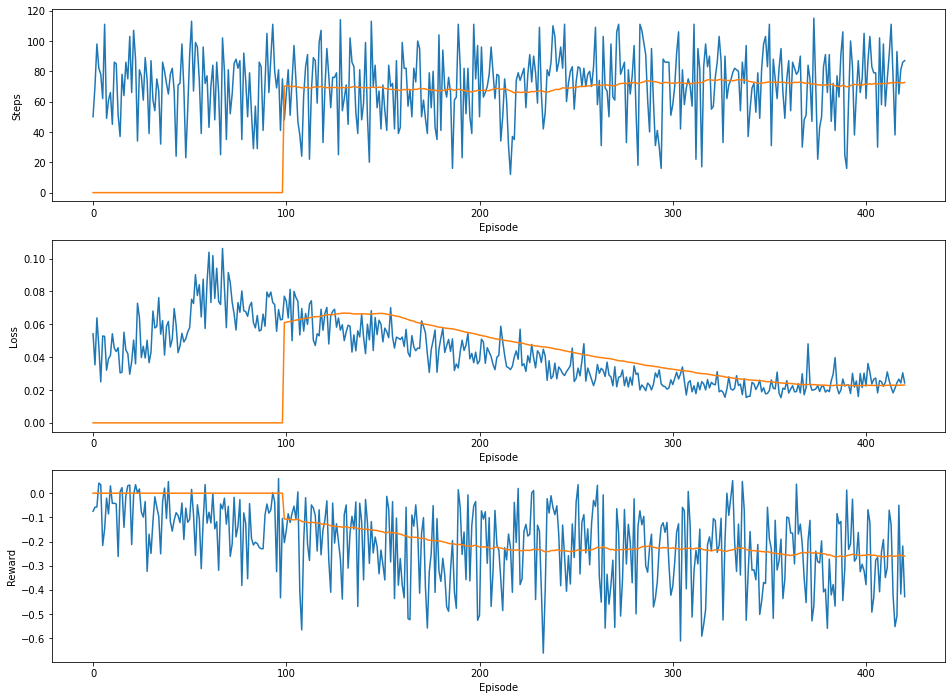

reward:  tensor([0.1049], device='cuda:0')
reward:  tensor([-0.6389], device='cuda:0')
reward:  tensor([-0.9861], device='cuda:0')
reward:  tensor([-0.8251], device='cuda:0')
reward:  tensor([-0.8332], device='cuda:0')
reward:  tensor([-1.0530], device='cuda:0')
reward:  tensor([-0.9740], device='cuda:0')
reward:  tensor([-0.6169], device='cuda:0')
reward:  tensor([-0.2001], device='cuda:0')
reward:  tensor([-0.6570], device='cuda:0')
DirectFlight(player=5, destination=44) 0.01491110011343777
DirectFlight(player=5, destination=32) 0.01591110011343777
DirectFlight(player=5, destination=19) 0.009955550056718884
DriveFerry(player=5, destination=8) 0.010955550056718884
Wait 0.010955550056718884
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
CharterFlight(player=7, destination=40) 0.01891110011343777
DriveFerry(player=7, destination=22) 0.019911100113437767
CharterFlight(player=7, destination=41) 0.013955550056718884
DriveFerry(player=7, destination=42) 0.0149555

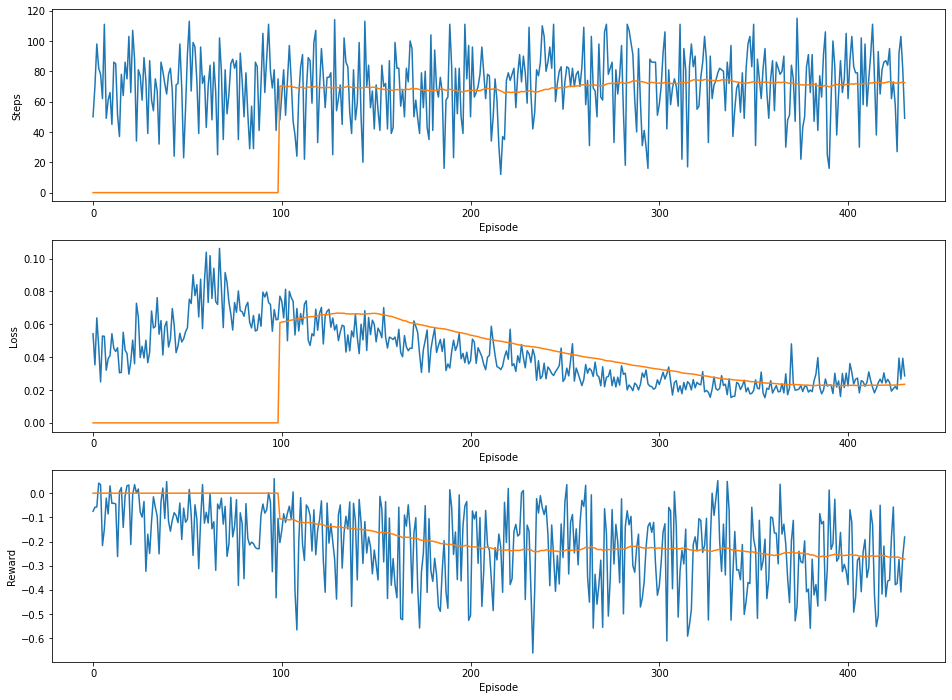

reward:  tensor([-1.0211], device='cuda:0')
reward:  tensor([-0.9791], device='cuda:0')
reward:  tensor([-1.0021], device='cuda:0')
reward:  tensor([-0.6709], device='cuda:0')
reward:  tensor([-0.3983], device='cuda:0')
reward:  tensor([-0.0959], device='cuda:0')
reward:  tensor([-0.2690], device='cuda:0')
reward:  tensor([-0.4052], device='cuda:0')
reward:  tensor([0.0810], device='cuda:0')
reward:  tensor([-0.5320], device='cuda:0')
DirectFlight(player=5, destination=40) 0.007955550056718885
DriveFerry(player=5, destination=6) 0.008955550056718884
DriveFerry(player=5, destination=29) 0.009955550056718884
DriveFerry(player=5, destination=28) 0.010955550056718884
OneQuietNight(player=5) 0.011955550056718885
Airlift(player=5, target_player=5, destination=20) 0.012955550056718885
Wait 0.012955550056718885
DriveFerry(player=7, destination=10) 0.013955550056718884
DriveFerry(player=7, destination=38) 0.014955550056718885
DriveFerry(player=7, destination=10) 0.015955550056718885
DriveFerry(

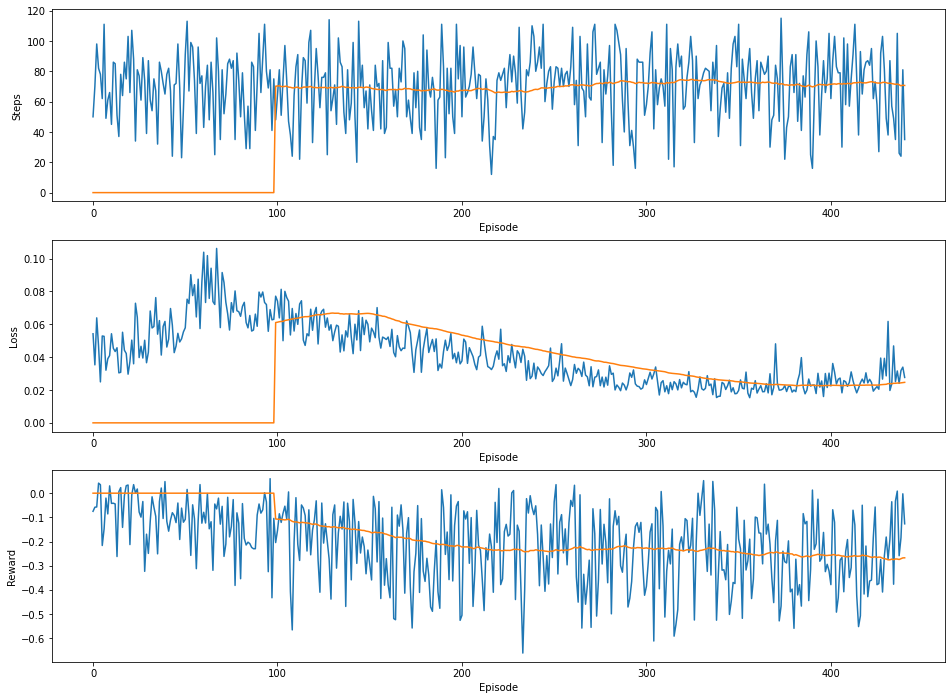

reward:  tensor([0.1010], device='cuda:0')
reward:  tensor([-0.8212], device='cuda:0')


In [0]:
num_episodes = 1000
memory_push = memory.push
episode_durations_append = episode_durations.append
episode_reward_append = episode_reward.append
step_rewards = []
step_rewards_append = step_rewards.append
step_rewards_clear = step_rewards.clear

for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    state = get_state(env)
    step_rewards_clear() 
    for t in count():
        # Select and perform an action
        action = select_action(state, env.action_space)
        _, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device).float()
        # Observe new state
        if not done:
            next_state = get_state(env)
            step_rewards_append(reward)
        else:
            print("reward: ", reward)
            next_state = None

        # Store the transition in memory
        memory_push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model(done)
        if done:
            episode_durations_append(info["steps"])
            episode_reward_append(torch.cat(step_rewards).mean(0))
            if i_episode % PLOT_STEPS == 0:
                env.render()
                plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
